In [1]:
# create a character level Fuel dataset from text file

%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

In [2]:
import os
import codecs
import subprocess
from subprocess import Popen, PIPE, STDOUT
from toolz import merge

import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.debug("test")

import numpy as np
from abc import ABCMeta, abstractmethod
from toolz import merge
import pandas as pd
from six import add_metaclass
from picklable_itertools.extras import equizip
from blocks.bricks.recurrent import (GatedRecurrent, Bidirectional)
from blocks.initialization import IsotropicGaussian, Constant, Orthogonal
import theano
import theano.tensor as T

from blocks.bricks import Initializable
from blocks.bricks.base import application, Brick, lazy
from blocks.bricks import Tanh, Linear, MLP
from blocks.bricks.lookup import LookupTable
from blocks.bricks.parallel import Fork
from blocks.utils import (shared_floatx_nans, dict_union)
from blocks.roles import add_role, WEIGHT
from blocks.bricks import Tanh, Linear, Softmax, MLP
from blocks.extensions.saveload import Checkpoint


from fuel.datasets import TextFile
from fuel.schemes import ConstantScheme
from fuel.streams import DataStream
from fuel.transformers import (
    Merge, Batch, Filter, Padding, SortMapping, Unpack, Mapping)

DEBUG:root:test


In [3]:
# path to your training data
TRAINING_DATASET = '/home/chris/projects/machine_learning/dcu-character-lms/data/paul_graham_essays.train.txt'
DEV_DATASET = '/home/chris/projects/machine_learning/dcu-character-lms/data/paul_graham_essays.dev.txt'

UNKNOWN_TOKEN = '|'
EOS_TOKEN = '`'

In [4]:
def get_vocab(dataset):
    all_symbols = set()
    with codecs.open(dataset, encoding='utf8') as inp: 
        for l in inp.read().strip().split('\n'):
            all_symbols.update(l)
    return all_symbols
    
    
def get_y_file(dataset):
    
    # a file to hold the Y representation of the dataset
    y_tmp_file = os.path.join(os.path.basename(dataset), dataset+'_temp_y.txt')
    
    with codecs.open(dataset, encoding='utf8') as inp:
        with codecs.open(
            y_tmp_file, 'wb',encoding='utf8') as y_out:
            for l in inp.read().strip().split('\n'):
                y_seq = l[1:] + EOS_TOKEN
                assert len(l) == len(y_seq)
    
                y_out.write(''.join(y_seq) + '\n')

    return y_tmp_file

In [5]:
class CharTextFile(TextFile):
    def __init__(self, *args, **kwargs):
        super(CharTextFile, self).__init__(*args, **kwargs)
    
    # override parent method to only do rstrip instead of strip
    def get_data(self, state=None, request=None):
        if request is not None:
            raise ValueError
        sentence = next(state)
        if self.preprocess is not None:
            sentence = self.preprocess(sentence)
        data = [self.dictionary[self.bos_token]] if self.bos_token else []
        if self.level == 'word':
            data.extend(self.dictionary.get(word,
                                            self.dictionary[self.unk_token])
                        for word in sentence.split())
        else:
            data.extend(self.dictionary.get(char,
                                            self.dictionary[self.unk_token])
                        for char in sentence.rstrip())
        if self.eos_token:
            data.append(self.dictionary[self.eos_token])
        return (data,)

In [6]:
# add an unknown token in case we observe a new character at prediction time
vocab = get_vocab(TRAINING_DATASET)
vocab.update([UNKNOWN_TOKEN, EOS_TOKEN])
word2idx = {v:k for k,v in enumerate(vocab)}

idx2word = {v:k for k,v in word2idx.items()}

In [7]:
from fuel.datasets import TextFile
from fuel.schemes import ConstantScheme
from fuel.streams import DataStream
from fuel.transformers import (
    Merge, Batch, Filter, Padding, SortMapping, Unpack, Mapping)


# axis swapping so that we get (time, batch, features)
def swapaxes(data):
    """Switch the axes in the sequence parts of the data tuple"""
    return tuple(array.swapaxes(0,1) for array in data)

class _too_long(object):
    """Filters sequences longer than given sequence length."""
    def __init__(self, seq_len=50):
        self.seq_len = seq_len

    def __call__(self, sentence_pair):
        return all([len(sentence) <= self.seq_len
                    for sentence in sentence_pair])


def get_stream(vocab, x_file,
               seq_len=50, batch_size=20, sort_k_batches=5, unk_token="`", **kwargs):
    """Prepares the data stream."""
    
    y_file = get_y_file(x_file)

    def _length(item):
        """Item is assumed to be (x,y)"""
        return len(item[0])
    
    # Get text files from both source and target
    X = CharTextFile([x_file], vocab, bos_token=None, eos_token=None,
                 unk_token=unk_token, level='character')

    Y = CharTextFile([y_file], vocab, bos_token=None, eos_token=None,
                 unk_token=unk_token, level='character')

    # Merge them to get x1, x2 pairs
    stream = Merge([X.get_example_stream(),
                    Y.get_example_stream()],
                    ('x', 'y'))

    # Filter sequences that are too long
    stream = Filter(stream, predicate=_too_long(seq_len=seq_len))

    # LOOKAHEAD SORT
    # Build a batched version of stream to read k batches ahead
#     stream = Batch(stream,
#                    iteration_scheme=ConstantScheme(
#                    batch_size*sort_k_batches))
    
    # Sort all samples in the read-ahead batch
#     stream = Mapping(stream, SortMapping(_length))

    # Convert it into a stream again
#     stream = Unpack(stream)
    # END LOOKAHEAD SORT

    # Construct batches from the stream with specified batch size
    stream = Batch(
        stream, iteration_scheme=ConstantScheme(batch_size))

    # Pad sequences that are short
    masked_stream = Padding(stream)
    
    # transpose tensors to get (time, batch, features)
    masked_stream = Mapping(masked_stream, swapaxes)

    return masked_stream

In [116]:
BATCH_SIZE = 20
MAX_SEQ_LEN = 200

train_stream = get_stream(word2idx, TRAINING_DATASET, batch_size=BATCH_SIZE, seq_len=MAX_SEQ_LEN)
dev_stream = get_stream(word2idx, DEV_DATASET, batch_size=BATCH_SIZE)

In [118]:
# Create the Model

class RNNLM(Initializable):
    """Model for character level LM"""

    def __init__(self, vocab_size, embedding_dim, state_dim, output_dim, **kwargs):
        super(RNNLM, self).__init__(**kwargs)
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.state_dim = state_dim
        self.output_dim = output_dim

        
        self.lookup = LookupTable(name='embeddings')
        self.transition = GatedRecurrent(activation=Tanh(), dim=state_dim)
        
        self.fork = Fork(
            [name for name in self.transition.apply.sequences
             if name != 'mask'], prototype=Linear(), name='fork')

        # output layer -- this may need to be changed
        self.output_layer = Linear(name='output_layer')
        
        self.children = [self.lookup, self.transition,
                         self.fork, self.output_layer]


    def _push_allocation_config(self):
        self.lookup.length = self.vocab_size
        self.lookup.dim = self.embedding_dim

        self.fork.input_dim = self.embedding_dim
        self.fork.output_dims = [self.transition.get_dim(name)
                                 for name in self.fork.output_names]
        
        self.output_layer.input_dim = self.state_dim
        self.output_layer.output_dim = self.output_dim

    def cost(self, x, x_mask, y, y_mask):
        
        representation = self.lookup.apply(x)
        
        states = self.transition.apply(**merge(self.fork.apply(representation, as_dict=True), {'mask': x_mask}))
        
        # get cost from output layer, transform inputs as necessary
        states_shape = states.shape
        states_dim1 = states_shape[0] * states_shape[1]
        states_dim2 = states_shape[2]

        y_hat = Softmax().apply(
            self.output_layer.apply(states.reshape((states_dim1, states_dim2))))

        y_preds = y_hat.argmax(axis=1)

        y = y.flatten()
        costs = T.nnet.categorical_crossentropy(y_hat, y)

        flat_y_mask = y_mask.flatten()

        # here we are zeroing the fake costs for masked parts of the predictions, and dividing by the number of actual
        # instances
        final_cost = T.sum(costs * flat_y_mask) / T.sum(flat_y_mask)
        
        return final_cost

In [119]:
VOCAB_SIZE = len(word2idx)
STATE_DIM=100
EMBEDDING_DIM=52
OUTPUT_DIM=len(word2idx)
SAVE_PATH='test_model_checkpoint'

test_rnnlm = RNNLM(VOCAB_SIZE, EMBEDDING_DIM, STATE_DIM, OUTPUT_DIM)

In [120]:
# initialize for testing
test_rnnlm.weights_init = IsotropicGaussian(0.1)
test_rnnlm.biases_init = Constant(0)
test_rnnlm.push_initialization_config()
test_rnnlm.initialize()

In [121]:
# Make symbolic variables
x = T.lmatrix("x")
x_mask = T.matrix("x_mask")
y = T.lmatrix("y")
y_mask = T.matrix("y_mask")

cost = test_rnnlm.cost(x, x_mask, y, y_mask)
cost.name = 'minibatch_cost'

# test_cost_func = theano.function([x, x_mask, y, y_mask], test_val)

In [122]:
import pprint

from blocks.monitoring import aggregation
from blocks.graph import ComputationGraph, apply_noise
from blocks.model import Model
from blocks.algorithms import (GradientDescent, Scale,
                               StepClipping, CompositeRule, AdaDelta, Adam)
from blocks.extensions.monitoring import TrainingDataMonitoring, DataStreamMonitoring
from blocks.main_loop import MainLoop
from blocks.extensions import FinishAfter, Printing, Timing
from blocks.extensions.stopping import FinishIfNoImprovementAfter
from blocks.graph import apply_dropout, apply_noise

# create the Blocks main loop
cost_cg = ComputationGraph(cost)
model = Model(cost)

algorithm = GradientDescent(
    cost=cost, parameters=cost_cg.parameters,
    step_rule=CompositeRule([StepClipping(1.),
                             AdaDelta()])
)

parameters = model.get_parameter_dict()
logger.info("Parameters:\n" +
                pprint.pformat(
                    [(key, value.get_value().shape) for key, value in parameters.items()],
                    width=120))

# Note that observables also get added to the log -- this is useful for post-processing
observables = [cost]


extensions = [
#     Timing(every_n_batches=1),
    TrainingDataMonitoring(observables, after_batch=True),
    DataStreamMonitoring(
        [cost],
        data_stream=dev_stream,
        prefix="valid",
        every_n_batches=10
    ),
    FinishAfter(after_n_batches=5000),
    Printing(every_n_batches=1, after_epoch=False),
    Checkpoint(SAVE_PATH, every_n_batches=100, save_separately=['log'])
]


main_loop = MainLoop(
    model=model,
    data_stream=train_stream,
    algorithm=algorithm,
    extensions=extensions
)

main_loop.run()


INFO:blocks.algorithms:Taking the cost gradient
INFO:blocks.algorithms:The cost gradient computation graph is built
INFO:root:Parameters:
[('/output_layer.b', (52,)),
 ('/gatedrecurrent.initial_state', (100,)),
 ('/fork/fork_gate_inputs.b', (200,)),
 ('/fork/fork_gate_inputs.W', (52, 200)),
 ('/fork/fork_inputs.b', (100,)),
 ('/fork/fork_inputs.W', (52, 100)),
 ('/embeddings.W', (52, 52)),
 ('/gatedrecurrent.state_to_gates', (100, 200)),
 ('/gatedrecurrent.state_to_state', (100, 100)),
 ('/output_layer.W', (100, 52))]
DEBUG:blocks.monitoring.evaluators:variable to evaluate: minibatch_cost
DEBUG:blocks.monitoring.evaluators:Using the default  (average over minibatches) aggregation scheme for minibatch_cost
DEBUG:blocks.monitoring.evaluators:Compiling initialization and readout functions
DEBUG:blocks.monitoring.evaluators:Initialization and readout functions compiled
DEBUG:blocks.monitoring.evaluators:variable to evaluate: minibatch_cost
DEBUG:blocks.monitoring.evaluators:Compiling initi


-------------------------------------------------------------------------------
BEFORE FIRST EPOCH
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 0
	 received_first_batch: False
	 resumed_from: None
	 training_started: True
Log records from the iteration 0:
	 valid_minibatch_cost: 3.95079088211


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 1
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1:
	 minibatch_cost: 3.95165586472


-----------------------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 9
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 9:
	 minibatch_cost: 3.57130098343


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 10
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 10:
	 minibatch_cost: 3.36391735077
	 valid_minibatch_cost: 3.29373288155


----------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 19
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 19:
	 minibatch_cost: 3.03418827057


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 20
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 20:
	 minibatch_cost: 3.07075190544
	 valid_minibatch_cost: 3.07188725471


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 29
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 29:
	 minibatch_cost: 3.07703351974


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 30
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 30:
	 minibatch_cost: 3.0665769577
	 valid_minibatch_cost: 3.02733540535


---------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 39
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 39:
	 minibatch_cost: 2.93935751915


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 40
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 40:
	 minibatch_cost: 2.96135640144
	 valid_minibatch_cost: 3.00131368637


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 49
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 49:
	 minibatch_cost: 2.87873721123


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 50
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 50:
	 minibatch_cost: 2.95614147186
	 valid_minibatch_cost: 2.94993638992


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 59
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 59:
	 minibatch_cost: 2.84636735916




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 0
	 iterations_done: 60
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 60:
	 minibatch_cost: 2.8172082901
	 valid_minibatch_cost: 2.89411306381


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 61
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 61:
	 minibatch_cost: 2.84821891785


---------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 69
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 69:
	 minibatch_cost: 2.80208086967


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 70
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 70:
	 minibatch_cost: 2.79993462563
	 valid_minibatch_cost: 2.8509786129


---------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 79
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 79:
	 minibatch_cost: 2.69440221786


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 80
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 80:
	 minibatch_cost: 2.71940970421
	 valid_minibatch_cost: 2.76011562347


--------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 89
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 89:
	 minibatch_cost: 2.6979765892


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 90
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 90:
	 minibatch_cost: 2.70491147041
	 valid_minibatch_cost: 2.6946978569


----------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 99
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 99:
	 minibatch_cost: 2.60106301308


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 100
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 100:
	 minibatch_cost: 2.58564162254
	 valid_minibatch_cost: 2.64485645294


------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 109
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 109:
	 minibatch_cost: 2.52870821953


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 110
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 110:
	 minibatch_cost: 2.62801980972
	 valid_minibatch_cost: 2.5959687233


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 119
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 119:
	 minibatch_cost: 2.57036662102




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 1
	 iterations_done: 120
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 120:
	 minibatch_cost: 2.45902252197
	 valid_minibatch_cost: 2.56174230576


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 121
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 121:
	 minibatch_cost: 2.46815156937


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 129
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 129:
	 minibatch_cost: 2.46993756294


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 130
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 130:
	 minibatch_cost: 2.50240731239
	 valid_minibatch_cost: 2.54480671883


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 139
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 139:
	 minibatch_cost: 2.40713477135


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 140
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 140:
	 minibatch_cost: 2.43765878677
	 valid_minibatch_cost: 2.52385139465


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 149
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 149:
	 minibatch_cost: 2.43010878563


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 150
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 150:
	 minibatch_cost: 2.47414398193
	 valid_minibatch_cost: 2.51146006584


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 159
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 159:
	 minibatch_cost: 2.44362807274


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 160
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 160:
	 minibatch_cost: 2.43199276924
	 valid_minibatch_cost: 2.49503993988


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 169
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 169:
	 minibatch_cost: 2.38479399681


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 170
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 170:
	 minibatch_cost: 2.51380848885
	 valid_minibatch_cost: 2.47072148323


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 179
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 179:
	 minibatch_cost: 2.47023820877




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 2
	 iterations_done: 180
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 180:
	 minibatch_cost: 2.36345458031
	 valid_minibatch_cost: 2.44695663452


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 181
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 181:
	 minibatch_cost: 2.3549156189


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 189
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 189:
	 minibatch_cost: 2.33241581917


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 190
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 190:
	 minibatch_cost: 2.3905043602
	 valid_minibatch_cost: 2.43603396416


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 199
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 199:
	 minibatch_cost: 2.29966616631


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 200
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 200:
	 minibatch_cost: 2.31431388855
	 valid_minibatch_cost: 2.42158102989


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 209
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 209:
	 minibatch_cost: 2.32779073715


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 210
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 210:
	 minibatch_cost: 2.3708460331
	 valid_minibatch_cost: 2.41368484497


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 219
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 219:
	 minibatch_cost: 2.35034942627


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 220
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 220:
	 minibatch_cost: 2.33405900002
	 valid_minibatch_cost: 2.3921482563


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 229
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 229:
	 minibatch_cost: 2.32318472862


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 230
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 230:
	 minibatch_cost: 2.44757342339
	 valid_minibatch_cost: 2.40863466263


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 239
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 239:
	 minibatch_cost: 2.3915014267




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 3
	 iterations_done: 240
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 240:
	 minibatch_cost: 2.29563307762
	 valid_minibatch_cost: 2.36024141312


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 241
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 241:
	 minibatch_cost: 2.26820778847


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 249
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 249:
	 minibatch_cost: 2.23076915741


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 250
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 250:
	 minibatch_cost: 2.31256175041
	 valid_minibatch_cost: 2.36308717728


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 259
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 259:
	 minibatch_cost: 2.20917081833


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 260
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 260:
	 minibatch_cost: 2.22260499001
	 valid_minibatch_cost: 2.35073828697


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 269
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 269:
	 minibatch_cost: 2.23844885826


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 270
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 270:
	 minibatch_cost: 2.29354047775
	 valid_minibatch_cost: 2.34567213058


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 279
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 279:
	 minibatch_cost: 2.27046918869


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 280
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 280:
	 minibatch_cost: 2.25558686256
	 valid_minibatch_cost: 2.3193860054


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 289
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 289:
	 minibatch_cost: 2.20251011848


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 290
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 290:
	 minibatch_cost: 2.34920048714
	 valid_minibatch_cost: 2.31493425369


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 299
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 299:
	 minibatch_cost: 2.31667160988




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 4
	 iterations_done: 300
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 300:
	 minibatch_cost: 2.23650527
	 valid_minibatch_cost: 2.29403829575


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 301
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 301:
	 minibatch_cost: 2.19524979591


-------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 309
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 309:
	 minibatch_cost: 2.1417901516


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 310
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 310:
	 minibatch_cost: 2.23819088936
	 valid_minibatch_cost: 2.28758215904


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 319
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 319:
	 minibatch_cost: 2.12622475624


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 320
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 320:
	 minibatch_cost: 2.13908600807
	 valid_minibatch_cost: 2.27766180038


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 329
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 329:
	 minibatch_cost: 2.16072177887


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 330
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 330:
	 minibatch_cost: 2.21089076996
	 valid_minibatch_cost: 2.27140974998


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 339
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 339:
	 minibatch_cost: 2.20078253746


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 340
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 340:
	 minibatch_cost: 2.18901753426
	 valid_minibatch_cost: 2.2509086132


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 349
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 349:
	 minibatch_cost: 2.14771866798


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 350
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 350:
	 minibatch_cost: 2.30440974236
	 valid_minibatch_cost: 2.27571320534


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 359
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 359:
	 minibatch_cost: 2.25945520401




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 5
	 iterations_done: 360
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 360:
	 minibatch_cost: 2.18252873421
	 valid_minibatch_cost: 2.22588801384


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 361
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 361:
	 minibatch_cost: 2.11910533905


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 369
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 369:
	 minibatch_cost: 2.06843948364


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 370
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 370:
	 minibatch_cost: 2.17455887794
	 valid_minibatch_cost: 2.22644495964


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 379
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 379:
	 minibatch_cost: 2.04909777641


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 380
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 380:
	 minibatch_cost: 2.06441617012
	 valid_minibatch_cost: 2.21558499336


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 389
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 389:
	 minibatch_cost: 2.08898210526


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 390
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 390:
	 minibatch_cost: 2.14414834976
	 valid_minibatch_cost: 2.2127995491


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 399
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 399:
	 minibatch_cost: 2.13978886604


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 400
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 400:
	 minibatch_cost: 2.13010883331
	 valid_minibatch_cost: 2.19243955612


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 409
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 409:
	 minibatch_cost: 2.07253170013


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 410
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 410:
	 minibatch_cost: 2.2382414341
	 valid_minibatch_cost: 2.21490716934


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 419
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 419:
	 minibatch_cost: 2.20789599419




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 6
	 iterations_done: 420
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 420:
	 minibatch_cost: 2.13225626945
	 valid_minibatch_cost: 2.17306637764


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 421
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 421:
	 minibatch_cost: 2.05510258675


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 429
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 429:
	 minibatch_cost: 2.00220823288


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 430
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 430:
	 minibatch_cost: 2.11135816574
	 valid_minibatch_cost: 2.16898107529


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 439
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 439:
	 minibatch_cost: 1.98324811459


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 440
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 440:
	 minibatch_cost: 1.99912059307
	 valid_minibatch_cost: 2.16204977036


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 449
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 449:
	 minibatch_cost: 2.02598786354


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 450
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 450:
	 minibatch_cost: 2.08788108826
	 valid_minibatch_cost: 2.16276073456


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 459
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 459:
	 minibatch_cost: 2.08553123474


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 460
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 460:
	 minibatch_cost: 2.07972288132
	 valid_minibatch_cost: 2.14184951782


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 469
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 469:
	 minibatch_cost: 2.00594949722


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 470
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 470:
	 minibatch_cost: 2.17532229424
	 valid_minibatch_cost: 2.16254234314


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 479
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 479:
	 minibatch_cost: 2.16295814514




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 7
	 iterations_done: 480
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 480:
	 minibatch_cost: 2.0866048336
	 valid_minibatch_cost: 2.12930893898


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 481
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 481:
	 minibatch_cost: 1.99990415573


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 489
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 489:
	 minibatch_cost: 1.94308853149


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 490
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 490:
	 minibatch_cost: 2.05554819107
	 valid_minibatch_cost: 2.1214017868


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 499
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 499:
	 minibatch_cost: 1.92322444916


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 500
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 500:
	 minibatch_cost: 1.9402192831
	 valid_minibatch_cost: 2.11638331413


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 509
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 509:
	 minibatch_cost: 1.96867072582


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 510
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 510:
	 minibatch_cost: 2.03932547569
	 valid_minibatch_cost: 2.12047958374


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 519
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 519:
	 minibatch_cost: 2.0363035202


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 520
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 520:
	 minibatch_cost: 2.03602814674
	 valid_minibatch_cost: 2.09862399101


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 529
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 529:
	 minibatch_cost: 1.94525802135


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 530
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 530:
	 minibatch_cost: 2.11479449272
	 valid_minibatch_cost: 2.11735963821


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 539
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 539:
	 minibatch_cost: 2.12259531021




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 8
	 iterations_done: 540
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 540:
	 minibatch_cost: 2.045566082
	 valid_minibatch_cost: 2.09216141701


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 541
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 541:
	 minibatch_cost: 1.95185053349


------------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 549
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 549:
	 minibatch_cost: 1.88828611374


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 550
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 550:
	 minibatch_cost: 2.0066049099
	 valid_minibatch_cost: 2.08195543289


-----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 559
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 559:
	 minibatch_cost: 1.86807346344


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 560
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 560:
	 minibatch_cost: 1.88641905785
	 valid_minibatch_cost: 2.07801699638


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 569
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 569:
	 minibatch_cost: 1.91627407074


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 570
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 570:
	 minibatch_cost: 1.99622762203
	 valid_minibatch_cost: 2.08515357971


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 579
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 579:
	 minibatch_cost: 1.99259614944


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 580
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 580:
	 minibatch_cost: 1.99720704556
	 valid_minibatch_cost: 2.06167411804


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 589
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 589:
	 minibatch_cost: 1.89039564133


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 590
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 590:
	 minibatch_cost: 2.05745053291
	 valid_minibatch_cost: 2.07812428474


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 599
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 599:
	 minibatch_cost: 2.0847401619




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 9
	 iterations_done: 600
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 600:
	 minibatch_cost: 2.00947451591
	 valid_minibatch_cost: 2.05962514877


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 601
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 601:
	 minibatch_cost: 1.90832841396


---------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 609
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 609:
	 minibatch_cost: 1.83740735054


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 610
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 610:
	 minibatch_cost: 1.96292674541
	 valid_minibatch_cost: 2.04789924622


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 619
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 619:
	 minibatch_cost: 1.81788790226


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 620
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 620:
	 minibatch_cost: 1.83760678768
	 valid_minibatch_cost: 2.04524731636


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 629
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 629:
	 minibatch_cost: 1.86843645573


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 630
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 630:
	 minibatch_cost: 1.95583117008
	 valid_minibatch_cost: 2.05434155464


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 639
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 639:
	 minibatch_cost: 1.95314085484


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 640
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 640:
	 minibatch_cost: 1.96200752258
	 valid_minibatch_cost: 2.02939939499


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 649
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 649:
	 minibatch_cost: 1.84113430977


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 650
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 650:
	 minibatch_cost: 2.00474500656
	 valid_minibatch_cost: 2.04359579086


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 659
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 659:
	 minibatch_cost: 2.04942917824




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 10
	 iterations_done: 660
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 660:
	 minibatch_cost: 1.97808516026
	 valid_minibatch_cost: 2.03027963638


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 661
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 661:
	 minibatch_cost: 1.86801326275


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 669
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 669:
	 minibatch_cost: 1.7907897234


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 670
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 670:
	 minibatch_cost: 1.9231274128
	 valid_minibatch_cost: 2.01679468155


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 679
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 679:
	 minibatch_cost: 1.77207767963


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 680
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 680:
	 minibatch_cost: 1.79326844215
	 valid_minibatch_cost: 2.01583528519


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 689
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 689:
	 minibatch_cost: 1.82482862473


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 690
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 690:
	 minibatch_cost: 1.91839361191
	 valid_minibatch_cost: 2.02618479729


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 699
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 699:
	 minibatch_cost: 1.9162569046


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 700
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 700:
	 minibatch_cost: 1.92968153954
	 valid_minibatch_cost: 2.00018119812


---------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 709
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 709:
	 minibatch_cost: 1.79641008377


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 710
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 710:
	 minibatch_cost: 1.95673847198
	 valid_minibatch_cost: 2.01220297813


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 719
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 719:
	 minibatch_cost: 2.01738286018




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 11
	 iterations_done: 720
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 720:
	 minibatch_cost: 1.94988930225
	 valid_minibatch_cost: 2.00317931175


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 721
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 721:
	 minibatch_cost: 1.83099114895


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 729
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 729:
	 minibatch_cost: 1.74868142605


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 730
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 730:
	 minibatch_cost: 1.88661444187
	 valid_minibatch_cost: 1.98728489876


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 739
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 739:
	 minibatch_cost: 1.72960960865


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 740
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 740:
	 minibatch_cost: 1.75243401527
	 valid_minibatch_cost: 1.98823904991


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 749
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 749:
	 minibatch_cost: 1.78540599346


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 750
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 750:
	 minibatch_cost: 1.88479828835
	 valid_minibatch_cost: 1.99942684174


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 759
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 759:
	 minibatch_cost: 1.88098633289


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 760
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 760:
	 minibatch_cost: 1.89981722832
	 valid_minibatch_cost: 1.97298300266


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 769
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 769:
	 minibatch_cost: 1.75544595718


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 770
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 770:
	 minibatch_cost: 1.91209411621
	 valid_minibatch_cost: 1.98294329643


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 779
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 779:
	 minibatch_cost: 1.98825311661




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 12
	 iterations_done: 780
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 780:
	 minibatch_cost: 1.92323040962
	 valid_minibatch_cost: 1.9777507782


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 781
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 781:
	 minibatch_cost: 1.79741621017


---------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 789
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 789:
	 minibatch_cost: 1.7108399868


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 790
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 790:
	 minibatch_cost: 1.85330021381
	 valid_minibatch_cost: 1.95925402641


---------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 799
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 799:
	 minibatch_cost: 1.69052898884


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 800
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 800:
	 minibatch_cost: 1.71480846405
	 valid_minibatch_cost: 1.96214103699


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 809
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 809:
	 minibatch_cost: 1.74955677986


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 810
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 810:
	 minibatch_cost: 1.85454595089
	 valid_minibatch_cost: 1.97359657288


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 819
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 819:
	 minibatch_cost: 1.84699761868


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 820
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 820:
	 minibatch_cost: 1.87224900723
	 valid_minibatch_cost: 1.94744515419


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 829
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 829:
	 minibatch_cost: 1.71779513359


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 830
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 830:
	 minibatch_cost: 1.86948180199
	 valid_minibatch_cost: 1.9555028677


---------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 839
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 839:
	 minibatch_cost: 1.96102631092




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 13
	 iterations_done: 840
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 840:
	 minibatch_cost: 1.89742827415
	 valid_minibatch_cost: 1.95387303829


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 841
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 841:
	 minibatch_cost: 1.76712405682


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 849
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 849:
	 minibatch_cost: 1.67666685581


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 850
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 850:
	 minibatch_cost: 1.82271718979
	 valid_minibatch_cost: 1.93299639225


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 859
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 859:
	 minibatch_cost: 1.65539681911


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 860
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 860:
	 minibatch_cost: 1.68029916286
	 valid_minibatch_cost: 1.93773436546


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 869
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 869:
	 minibatch_cost: 1.71624684334


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 870
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 870:
	 minibatch_cost: 1.82665133476
	 valid_minibatch_cost: 1.94906616211


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 879
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 879:
	 minibatch_cost: 1.81428456306


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 880
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 880:
	 minibatch_cost: 1.84674119949
	 valid_minibatch_cost: 1.92355024815


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 889
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 889:
	 minibatch_cost: 1.68298888206


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 890
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 890:
	 minibatch_cost: 1.82831978798
	 valid_minibatch_cost: 1.92993569374


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 899
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 899:
	 minibatch_cost: 1.9349168539




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 14
	 iterations_done: 900
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 900:
	 minibatch_cost: 1.87237751484
	 valid_minibatch_cost: 1.9315674305


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 901
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 901:
	 minibatch_cost: 1.73982954025


---------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 909
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 909:
	 minibatch_cost: 1.64552402496


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 910
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 910:
	 minibatch_cost: 1.79406714439
	 valid_minibatch_cost: 1.90871846676


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 919
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 919:
	 minibatch_cost: 1.62411391735


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 920
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 920:
	 minibatch_cost: 1.64865291119
	 valid_minibatch_cost: 1.91524338722


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 929
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 929:
	 minibatch_cost: 1.68470084667


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 930
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 930:
	 minibatch_cost: 1.80050349236
	 valid_minibatch_cost: 1.92638707161


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 939
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 939:
	 minibatch_cost: 1.78299868107


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 940
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 940:
	 minibatch_cost: 1.82278633118
	 valid_minibatch_cost: 1.90136885643


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 949
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 949:
	 minibatch_cost: 1.650562644


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 950
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 950:
	 minibatch_cost: 1.78856110573
	 valid_minibatch_cost: 1.90626549721


----------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 959
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 959:
	 minibatch_cost: 1.90962827206




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 15
	 iterations_done: 960
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 960:
	 minibatch_cost: 1.84812438488
	 valid_minibatch_cost: 1.91081404686


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 961
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 961:
	 minibatch_cost: 1.71506690979


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 969
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 969:
	 minibatch_cost: 1.61689734459


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 970
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 970:
	 minibatch_cost: 1.76677143574
	 valid_minibatch_cost: 1.88648152351


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 979
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 979:
	 minibatch_cost: 1.59611821175


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 980
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 980:
	 minibatch_cost: 1.61970436573
	 valid_minibatch_cost: 1.89475023746


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 989
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 989:
	 minibatch_cost: 1.6546241045


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 990
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 990:
	 minibatch_cost: 1.77594459057
	 valid_minibatch_cost: 1.90574288368


---------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 999
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 999:
	 minibatch_cost: 1.75327289104


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 1000
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1000:
	 minibatch_cost: 1.79984176159
	 valid_minibatch_cost: 1.88093030453


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 1009
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1009:
	 minibatch_cost: 1.62025809288


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 1010
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1010:
	 minibatch_cost: 1.75052845478
	 valid_minibatch_cost: 1.88450181484


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 1019
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1019:
	 minibatch_cost: 1.88515043259




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 16
	 iterations_done: 1020
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1020:
	 minibatch_cost: 1.8247563839
	 valid_minibatch_cost: 1.89156985283


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1021
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1021:
	 minibatch_cost: 1.69228029251


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1029
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1029:
	 minibatch_cost: 1.59044861794


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1030
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1030:
	 minibatch_cost: 1.74070084095
	 valid_minibatch_cost: 1.86622273922


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1039
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1039:
	 minibatch_cost: 1.57079708576


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1040
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1040:
	 minibatch_cost: 1.59333431721
	 valid_minibatch_cost: 1.87611424923


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1049
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1049:
	 minibatch_cost: 1.62603437901


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1050
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1050:
	 minibatch_cost: 1.7529374361
	 valid_minibatch_cost: 1.88699758053


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1059
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1059:
	 minibatch_cost: 1.72518861294


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1060
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1060:
	 minibatch_cost: 1.77765095234
	 valid_minibatch_cost: 1.8621994257


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1069
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1069:
	 minibatch_cost: 1.59199941158


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1070
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1070:
	 minibatch_cost: 1.71477770805
	 valid_minibatch_cost: 1.86466288567


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1079
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1079:
	 minibatch_cost: 1.86154258251




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 17
	 iterations_done: 1080
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1080:
	 minibatch_cost: 1.80228972435
	 valid_minibatch_cost: 1.87370276451


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1081
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1081:
	 minibatch_cost: 1.67097187042


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1089
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1089:
	 minibatch_cost: 1.56592547894


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1090
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1090:
	 minibatch_cost: 1.71591746807
	 valid_minibatch_cost: 1.8477640152


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1099
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1099:
	 minibatch_cost: 1.54765462875


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1100
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1100:
	 minibatch_cost: 1.56928098202
	 valid_minibatch_cost: 1.85900855064


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1109
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1109:
	 minibatch_cost: 1.59908020496


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1110
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1110:
	 minibatch_cost: 1.7312296629
	 valid_minibatch_cost: 1.86986470222


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1119
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1119:
	 minibatch_cost: 1.69877040386


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1120
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1120:
	 minibatch_cost: 1.75619804859
	 valid_minibatch_cost: 1.84508359432


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1129
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1129:
	 minibatch_cost: 1.56568241119


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1130
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1130:
	 minibatch_cost: 1.68173801899
	 valid_minibatch_cost: 1.84670519829


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1139
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1139:
	 minibatch_cost: 1.83884716034




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 18
	 iterations_done: 1140
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1140:
	 minibatch_cost: 1.78057515621
	 valid_minibatch_cost: 1.856995821


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1141
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1141:
	 minibatch_cost: 1.65074837208


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1149
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1149:
	 minibatch_cost: 1.54310500622


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1150
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1150:
	 minibatch_cost: 1.69241535664
	 valid_minibatch_cost: 1.8309109211


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1159
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1159:
	 minibatch_cost: 1.52628397942


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1160
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1160:
	 minibatch_cost: 1.54713451862
	 valid_minibatch_cost: 1.84310114384


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1169
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1169:
	 minibatch_cost: 1.5739107132


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1170
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1170:
	 minibatch_cost: 1.7104486227
	 valid_minibatch_cost: 1.85403561592


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1179
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1179:
	 minibatch_cost: 1.67400705814


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1180
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1180:
	 minibatch_cost: 1.73549807072
	 valid_minibatch_cost: 1.82944226265


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1189
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1189:
	 minibatch_cost: 1.54107177258


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1190
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1190:
	 minibatch_cost: 1.65142428875
	 valid_minibatch_cost: 1.83046889305


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1199
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1199:
	 minibatch_cost: 1.81706738472




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 19
	 iterations_done: 1200
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1200:
	 minibatch_cost: 1.75938129425
	 valid_minibatch_cost: 1.84125328064


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1201
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1201:
	 minibatch_cost: 1.63136708736


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1209
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1209:
	 minibatch_cost: 1.5218102932


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1210
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1210:
	 minibatch_cost: 1.6701002121
	 valid_minibatch_cost: 1.81553769112


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1219
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1219:
	 minibatch_cost: 1.5063457489


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1220
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1220:
	 minibatch_cost: 1.52649569511
	 valid_minibatch_cost: 1.82821369171


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1229
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1229:
	 minibatch_cost: 1.55053138733


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1230
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1230:
	 minibatch_cost: 1.69032919407
	 valid_minibatch_cost: 1.83927094936


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1239
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1239:
	 minibatch_cost: 1.65090489388


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1240
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1240:
	 minibatch_cost: 1.71555995941
	 valid_minibatch_cost: 1.81511902809


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1249
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1249:
	 minibatch_cost: 1.51790595055


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1250
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1250:
	 minibatch_cost: 1.62352132797
	 valid_minibatch_cost: 1.81572890282


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1259
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1259:
	 minibatch_cost: 1.79618740082




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 20
	 iterations_done: 1260
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1260:
	 minibatch_cost: 1.73860025406
	 valid_minibatch_cost: 1.82639503479


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1261
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1261:
	 minibatch_cost: 1.61273992062


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1269
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1269:
	 minibatch_cost: 1.50192582607


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1270
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1270:
	 minibatch_cost: 1.64883506298
	 valid_minibatch_cost: 1.80155849457


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1279
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1279:
	 minibatch_cost: 1.48756957054


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1280
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1280:
	 minibatch_cost: 1.50708305836
	 valid_minibatch_cost: 1.81429255009


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1289
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1289:
	 minibatch_cost: 1.52878165245


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1290
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1290:
	 minibatch_cost: 1.67075026035
	 valid_minibatch_cost: 1.8254404068


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1299
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1299:
	 minibatch_cost: 1.62951266766


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1300
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1300:
	 minibatch_cost: 1.69642043114
	 valid_minibatch_cost: 1.80196857452


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1309
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1309:
	 minibatch_cost: 1.49603438377


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1310
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1310:
	 minibatch_cost: 1.59763348103
	 valid_minibatch_cost: 1.80229222775


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1319
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1319:
	 minibatch_cost: 1.77622067928




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 21
	 iterations_done: 1320
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1320:
	 minibatch_cost: 1.71831834316
	 valid_minibatch_cost: 1.81246244907


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1321
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1321:
	 minibatch_cost: 1.59485793114


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1329
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1329:
	 minibatch_cost: 1.48338162899


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1330
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1330:
	 minibatch_cost: 1.62847077847
	 valid_minibatch_cost: 1.78886544704


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1339
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1339:
	 minibatch_cost: 1.46974372864


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1340
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1340:
	 minibatch_cost: 1.4887368679
	 valid_minibatch_cost: 1.80131494999


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1349
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1349:
	 minibatch_cost: 1.50845503807


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1350
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1350:
	 minibatch_cost: 1.65167081356
	 valid_minibatch_cost: 1.81250190735


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1359
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1359:
	 minibatch_cost: 1.60988605022


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1360
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1360:
	 minibatch_cost: 1.67812311649
	 valid_minibatch_cost: 1.7898607254


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1369
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1369:
	 minibatch_cost: 1.47539317608


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1370
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1370:
	 minibatch_cost: 1.57346653938
	 valid_minibatch_cost: 1.79003083706


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1379
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1379:
	 minibatch_cost: 1.75718700886




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 22
	 iterations_done: 1380
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1380:
	 minibatch_cost: 1.69868397713
	 valid_minibatch_cost: 1.79953289032


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1381
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1381:
	 minibatch_cost: 1.57769858837


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1389
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1389:
	 minibatch_cost: 1.46610462666


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1390
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1390:
	 minibatch_cost: 1.60888230801
	 valid_minibatch_cost: 1.77732121944


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1399
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1399:
	 minibatch_cost: 1.45272541046


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1400
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1400:
	 minibatch_cost: 1.47137343884
	 valid_minibatch_cost: 1.78924655914


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1409
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1409:
	 minibatch_cost: 1.48941493034


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1410
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1410:
	 minibatch_cost: 1.63310325146
	 valid_minibatch_cost: 1.80045056343


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1419
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1419:
	 minibatch_cost: 1.59200370312


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1420
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1420:
	 minibatch_cost: 1.66066658497
	 valid_minibatch_cost: 1.77867126465


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1429
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1429:
	 minibatch_cost: 1.4559315443


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1430
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1430:
	 minibatch_cost: 1.55086445808
	 valid_minibatch_cost: 1.77885222435


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1439
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1439:
	 minibatch_cost: 1.73907017708




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 23
	 iterations_done: 1440
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1440:
	 minibatch_cost: 1.67977201939
	 valid_minibatch_cost: 1.78764379025


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1441
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1441:
	 minibatch_cost: 1.56117594242


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1449
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1449:
	 minibatch_cost: 1.44999098778


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1450
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1450:
	 minibatch_cost: 1.5899913311
	 valid_minibatch_cost: 1.76678311825


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1459
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1459:
	 minibatch_cost: 1.43644857407


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1460
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1460:
	 minibatch_cost: 1.45492362976
	 valid_minibatch_cost: 1.77804064751


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1469
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1469:
	 minibatch_cost: 1.47160196304


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1470
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1470:
	 minibatch_cost: 1.61509144306
	 valid_minibatch_cost: 1.78928685188


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1479
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1479:
	 minibatch_cost: 1.57572281361


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1480
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1480:
	 minibatch_cost: 1.64400315285
	 valid_minibatch_cost: 1.76829528809


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1489
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1489:
	 minibatch_cost: 1.43758428097


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1490
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1490:
	 minibatch_cost: 1.5297614336
	 valid_minibatch_cost: 1.76867747307


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1499
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1499:
	 minibatch_cost: 1.72183275223




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 24
	 iterations_done: 1500
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1500:
	 minibatch_cost: 1.66158270836
	 valid_minibatch_cost: 1.77678132057


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1501
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1501:
	 minibatch_cost: 1.54518187046


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1509
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1509:
	 minibatch_cost: 1.43492412567


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1510
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1510:
	 minibatch_cost: 1.57175898552
	 valid_minibatch_cost: 1.75713133812


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1519
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1519:
	 minibatch_cost: 1.42089903355


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1520
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1520:
	 minibatch_cost: 1.43934357166
	 valid_minibatch_cost: 1.76767289639


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1529
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1529:
	 minibatch_cost: 1.45496618748


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1530
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1530:
	 minibatch_cost: 1.59768211842
	 valid_minibatch_cost: 1.77901268005


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1539
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1539:
	 minibatch_cost: 1.56080782413


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1540
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1540:
	 minibatch_cost: 1.6281042099
	 valid_minibatch_cost: 1.75866007805


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1549
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1549:
	 minibatch_cost: 1.42028331757


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1550
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1550:
	 minibatch_cost: 1.51012814045
	 valid_minibatch_cost: 1.75944674015


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1559
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1559:
	 minibatch_cost: 1.70544278622




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 25
	 iterations_done: 1560
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1560:
	 minibatch_cost: 1.64410865307
	 valid_minibatch_cost: 1.76689660549


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1561
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1561:
	 minibatch_cost: 1.52965426445


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1569
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1569:
	 minibatch_cost: 1.42079746723


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1570
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1570:
	 minibatch_cost: 1.55415904522
	 valid_minibatch_cost: 1.74828588963


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1579
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1579:
	 minibatch_cost: 1.40608179569


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1580
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1580:
	 minibatch_cost: 1.42468345165
	 valid_minibatch_cost: 1.75816309452


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1589
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1589:
	 minibatch_cost: 1.43940412998


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1590
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1590:
	 minibatch_cost: 1.58088541031
	 valid_minibatch_cost: 1.76962816715


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1599
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1599:
	 minibatch_cost: 1.54699587822


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1600
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1600:
	 minibatch_cost: 1.61297678947
	 valid_minibatch_cost: 1.74971389771


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1609
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1609:
	 minibatch_cost: 1.4039850235


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1610
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1610:
	 minibatch_cost: 1.49192762375
	 valid_minibatch_cost: 1.75111269951


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1619
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1619:
	 minibatch_cost: 1.68987762928




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 26
	 iterations_done: 1620
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1620:
	 minibatch_cost: 1.6273380518
	 valid_minibatch_cost: 1.75792121887


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1621
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1621:
	 minibatch_cost: 1.51459610462


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1629
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1629:
	 minibatch_cost: 1.40751814842


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1630
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1630:
	 minibatch_cost: 1.53716361523
	 valid_minibatch_cost: 1.74019885063


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1639
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1639:
	 minibatch_cost: 1.39199578762


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1640
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1640:
	 minibatch_cost: 1.4110199213
	 valid_minibatch_cost: 1.74953913689


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1649
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1649:
	 minibatch_cost: 1.42476141453


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1650
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1650:
	 minibatch_cost: 1.56466305256
	 valid_minibatch_cost: 1.7611156702


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1659
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1659:
	 minibatch_cost: 1.53407216072


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1660
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1660:
	 minibatch_cost: 1.59856033325
	 valid_minibatch_cost: 1.74142742157


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1669
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1669:
	 minibatch_cost: 1.38864815235


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1670
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1670:
	 minibatch_cost: 1.47506535053
	 valid_minibatch_cost: 1.74361288548


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1679
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1679:
	 minibatch_cost: 1.67511200905




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 27
	 iterations_done: 1680
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1680:
	 minibatch_cost: 1.61120676994
	 valid_minibatch_cost: 1.74977564812


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1681
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1681:
	 minibatch_cost: 1.50004827976


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1689
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1689:
	 minibatch_cost: 1.3950009346


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1690
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1690:
	 minibatch_cost: 1.52074193954
	 valid_minibatch_cost: 1.73283231258


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1699
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1699:
	 minibatch_cost: 1.37862145901


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1700
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1700:
	 minibatch_cost: 1.39830756187
	 valid_minibatch_cost: 1.74177646637


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1709
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1709:
	 minibatch_cost: 1.41088211536


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1710
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1710:
	 minibatch_cost: 1.54898130894
	 valid_minibatch_cost: 1.75343728065


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1719
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1719:
	 minibatch_cost: 1.52189290524


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1720
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1720:
	 minibatch_cost: 1.5847454071
	 valid_minibatch_cost: 1.73377931118


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1729
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1729:
	 minibatch_cost: 1.37418115139


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1730
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1730:
	 minibatch_cost: 1.45935916901
	 valid_minibatch_cost: 1.73686027527


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1739
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1739:
	 minibatch_cost: 1.66108644009




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 28
	 iterations_done: 1740
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1740:
	 minibatch_cost: 1.59561395645
	 valid_minibatch_cost: 1.74237728119


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1741
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1741:
	 minibatch_cost: 1.4860574007


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1749
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1749:
	 minibatch_cost: 1.38314640522


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1750
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1750:
	 minibatch_cost: 1.50485980511
	 valid_minibatch_cost: 1.72614252567


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1759
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1759:
	 minibatch_cost: 1.36591458321


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1760
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1760:
	 minibatch_cost: 1.38640916348
	 valid_minibatch_cost: 1.73479771614


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1769
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1769:
	 minibatch_cost: 1.39763998985


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1770
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1770:
	 minibatch_cost: 1.53383660316
	 valid_minibatch_cost: 1.74653553963


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1779
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1779:
	 minibatch_cost: 1.51035869122


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1780
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1780:
	 minibatch_cost: 1.57145619392
	 valid_minibatch_cost: 1.72672879696


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1789
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1789:
	 minibatch_cost: 1.36043822765


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1790
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1790:
	 minibatch_cost: 1.44457161427
	 valid_minibatch_cost: 1.73076307774


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1799
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1799:
	 minibatch_cost: 1.64769804478




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 29
	 iterations_done: 1800
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1800:
	 minibatch_cost: 1.58046102524
	 valid_minibatch_cost: 1.73565256596


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1801
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1801:
	 minibatch_cost: 1.47264635563


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1809
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1809:
	 minibatch_cost: 1.37182784081


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1810
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1810:
	 minibatch_cost: 1.48947286606
	 valid_minibatch_cost: 1.72007143497


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1819
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1819:
	 minibatch_cost: 1.35380530357


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1820
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1820:
	 minibatch_cost: 1.37517046928
	 valid_minibatch_cost: 1.72850453854


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1829
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1829:
	 minibatch_cost: 1.38493180275


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1830
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1830:
	 minibatch_cost: 1.51922655106
	 valid_minibatch_cost: 1.74033641815


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1839
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1839:
	 minibatch_cost: 1.49938821793


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1840
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1840:
	 minibatch_cost: 1.55866265297
	 valid_minibatch_cost: 1.72022306919


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1849
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1849:
	 minibatch_cost: 1.34725809097


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1850
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1850:
	 minibatch_cost: 1.43047451973
	 valid_minibatch_cost: 1.72524487972


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1859
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1859:
	 minibatch_cost: 1.63483250141




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 30
	 iterations_done: 1860
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1860:
	 minibatch_cost: 1.56567299366
	 valid_minibatch_cost: 1.72954750061


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1861
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1861:
	 minibatch_cost: 1.45980358124


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1869
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1869:
	 minibatch_cost: 1.36091387272


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1870
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1870:
	 minibatch_cost: 1.47452807426
	 valid_minibatch_cost: 1.71455156803


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1879
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1879:
	 minibatch_cost: 1.34221172333


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1880
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1880:
	 minibatch_cost: 1.36444807053
	 valid_minibatch_cost: 1.72280752659


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1889
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1889:
	 minibatch_cost: 1.37266790867


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1890
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1890:
	 minibatch_cost: 1.50512862206
	 valid_minibatch_cost: 1.73476624489


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1899
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1899:
	 minibatch_cost: 1.48890841007


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1900
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1900:
	 minibatch_cost: 1.54635465145
	 valid_minibatch_cost: 1.71421813965


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1909
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1909:
	 minibatch_cost: 1.33451533318


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1910
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1910:
	 minibatch_cost: 1.41688704491
	 valid_minibatch_cost: 1.7202476263


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1919
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1919:
	 minibatch_cost: 1.62240254879




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 31
	 iterations_done: 1920
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1920:
	 minibatch_cost: 1.55120384693
	 valid_minibatch_cost: 1.72403120995


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1921
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1921:
	 minibatch_cost: 1.44749248028


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1929
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1929:
	 minibatch_cost: 1.350304842


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1930
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1930:
	 minibatch_cost: 1.45998263359
	 valid_minibatch_cost: 1.70951771736


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1939
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1939:
	 minibatch_cost: 1.33105790615


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1940
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1940:
	 minibatch_cost: 1.35412085056
	 valid_minibatch_cost: 1.71763765812


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1949
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1949:
	 minibatch_cost: 1.36077523232


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1950
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1950:
	 minibatch_cost: 1.49151134491
	 valid_minibatch_cost: 1.72976994514


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1959
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1959:
	 minibatch_cost: 1.47885787487


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1960
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1960:
	 minibatch_cost: 1.5345236063
	 valid_minibatch_cost: 1.70869421959


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1969
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1969:
	 minibatch_cost: 1.32214951515


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1970
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1970:
	 minibatch_cost: 1.40367662907
	 valid_minibatch_cost: 1.7157227993


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1979
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1979:
	 minibatch_cost: 1.61036515236




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 32
	 iterations_done: 1980
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1980:
	 minibatch_cost: 1.53703153133
	 valid_minibatch_cost: 1.71909201145


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 1981
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1981:
	 minibatch_cost: 1.43566918373


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 1989
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1989:
	 minibatch_cost: 1.3399450779


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 1990
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1990:
	 minibatch_cost: 1.4458220005
	 valid_minibatch_cost: 1.70491504669


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 1999
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 1999:
	 minibatch_cost: 1.32028985023


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 2000
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2000:
	 minibatch_cost: 1.34409224987
	 valid_minibatch_cost: 1.71294820309


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 2009
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2009:
	 minibatch_cost: 1.34920334816


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 2010
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2010:
	 minibatch_cost: 1.47835087776
	 valid_minibatch_cost: 1.72531282902


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 2019
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2019:
	 minibatch_cost: 1.46919631958


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 2020
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2020:
	 minibatch_cost: 1.52315723896
	 valid_minibatch_cost: 1.70365738869


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 2029
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2029:
	 minibatch_cost: 1.31016218662


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 2030
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2030:
	 minibatch_cost: 1.39074766636
	 valid_minibatch_cost: 1.71162509918


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 2039
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2039:
	 minibatch_cost: 1.59872055054




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 33
	 iterations_done: 2040
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2040:
	 minibatch_cost: 1.52314662933
	 valid_minibatch_cost: 1.71472716331


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2041
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2041:
	 minibatch_cost: 1.42429053783


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2049
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2049:
	 minibatch_cost: 1.32980632782


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2050
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2050:
	 minibatch_cost: 1.43204879761
	 valid_minibatch_cost: 1.70070075989


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2059
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2059:
	 minibatch_cost: 1.30988121033


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2060
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2060:
	 minibatch_cost: 1.33427834511
	 valid_minibatch_cost: 1.70871138573


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2069
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2069:
	 minibatch_cost: 1.33792376518


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2070
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2070:
	 minibatch_cost: 1.46563673019
	 valid_minibatch_cost: 1.72137129307


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2079
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2079:
	 minibatch_cost: 1.4599095583


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2080
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2080:
	 minibatch_cost: 1.51223647594
	 valid_minibatch_cost: 1.69913101196


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2089
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2089:
	 minibatch_cost: 1.29858791828


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2090
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2090:
	 minibatch_cost: 1.37803006172
	 valid_minibatch_cost: 1.70791745186


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2099
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2099:
	 minibatch_cost: 1.58749914169




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 34
	 iterations_done: 2100
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2100:
	 minibatch_cost: 1.50954496861
	 valid_minibatch_cost: 1.71093630791


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2101
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2101:
	 minibatch_cost: 1.4133092165


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2109
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2109:
	 minibatch_cost: 1.31985878944


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2110
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2110:
	 minibatch_cost: 1.41865122318
	 valid_minibatch_cost: 1.69684720039


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2119
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2119:
	 minibatch_cost: 1.29982960224


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2120
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2120:
	 minibatch_cost: 1.32459115982
	 valid_minibatch_cost: 1.70492053032


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2129
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2129:
	 minibatch_cost: 1.32691979408


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2130
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2130:
	 minibatch_cost: 1.45336341858
	 valid_minibatch_cost: 1.71792757511


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2139
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2139:
	 minibatch_cost: 1.45100271702


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2140
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2140:
	 minibatch_cost: 1.5017311573
	 valid_minibatch_cost: 1.69514369965


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2149
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2149:
	 minibatch_cost: 1.28745675087


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2150
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2150:
	 minibatch_cost: 1.36547577381
	 valid_minibatch_cost: 1.7045814991


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2159
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2159:
	 minibatch_cost: 1.57673561573




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 35
	 iterations_done: 2160
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2160:
	 minibatch_cost: 1.49623799324
	 valid_minibatch_cost: 1.70771813393


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2161
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2161:
	 minibatch_cost: 1.40267825127


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2169
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2169:
	 minibatch_cost: 1.31005477905


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2170
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2170:
	 minibatch_cost: 1.4055866003
	 valid_minibatch_cost: 1.69334030151


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2179
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2179:
	 minibatch_cost: 1.29013586044


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2180
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2180:
	 minibatch_cost: 1.31493842602
	 valid_minibatch_cost: 1.70158958435


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2189
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2189:
	 minibatch_cost: 1.31616461277


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2190
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2190:
	 minibatch_cost: 1.44152367115
	 valid_minibatch_cost: 1.71497607231


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2199
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2199:
	 minibatch_cost: 1.44247496128


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2200
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2200:
	 minibatch_cost: 1.49160301685
	 valid_minibatch_cost: 1.69171845913


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2209
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2209:
	 minibatch_cost: 1.2767688036


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2210
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2210:
	 minibatch_cost: 1.35307204723
	 valid_minibatch_cost: 1.70161724091


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2219
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2219:
	 minibatch_cost: 1.56644010544




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 36
	 iterations_done: 2220
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2220:
	 minibatch_cost: 1.48326659203
	 valid_minibatch_cost: 1.70506894588


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2221
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2221:
	 minibatch_cost: 1.39236295223


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2229
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2229:
	 minibatch_cost: 1.30033564568


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2230
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2230:
	 minibatch_cost: 1.39280366898
	 valid_minibatch_cost: 1.69017505646


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2239
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2239:
	 minibatch_cost: 1.28078258038


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2240
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2240:
	 minibatch_cost: 1.30524551868
	 valid_minibatch_cost: 1.69874215126


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2249
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2249:
	 minibatch_cost: 1.30560922623


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2250
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2250:
	 minibatch_cost: 1.43010926247
	 valid_minibatch_cost: 1.71253037453


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2259
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2259:
	 minibatch_cost: 1.43428623676


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2260
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2260:
	 minibatch_cost: 1.481803298
	 valid_minibatch_cost: 1.68886852264


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2269
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2269:
	 minibatch_cost: 1.26648914814


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2270
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2270:
	 minibatch_cost: 1.34085583687
	 valid_minibatch_cost: 1.69903624058


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2279
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2279:
	 minibatch_cost: 1.55658149719




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 37
	 iterations_done: 2280
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2280:
	 minibatch_cost: 1.47069740295
	 valid_minibatch_cost: 1.70297122002


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2281
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2281:
	 minibatch_cost: 1.38233876228


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2289
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2289:
	 minibatch_cost: 1.29066705704


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2290
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2290:
	 minibatch_cost: 1.38031208515
	 valid_minibatch_cost: 1.68735826015


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2299
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2299:
	 minibatch_cost: 1.27172589302


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2300
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2300:
	 minibatch_cost: 1.29548048973
	 valid_minibatch_cost: 1.69639718533


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2309
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2309:
	 minibatch_cost: 1.2951977253


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2310
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2310:
	 minibatch_cost: 1.41912031174
	 valid_minibatch_cost: 1.71060752869


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2319
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2319:
	 minibatch_cost: 1.42635166645


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2320
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2320:
	 minibatch_cost: 1.47227263451
	 valid_minibatch_cost: 1.68659758568


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2329
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2329:
	 minibatch_cost: 1.25655949116


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2330
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2330:
	 minibatch_cost: 1.32890295982
	 valid_minibatch_cost: 1.69685709476


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2339
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2339:
	 minibatch_cost: 1.54709243774




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 38
	 iterations_done: 2340
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2340:
	 minibatch_cost: 1.45859718323
	 valid_minibatch_cost: 1.70138418674


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2341
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2341:
	 minibatch_cost: 1.37257909775


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2349
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2349:
	 minibatch_cost: 1.28107774258


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2350
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2350:
	 minibatch_cost: 1.36825728416
	 valid_minibatch_cost: 1.68493330479


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2359
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2359:
	 minibatch_cost: 1.26290786266


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2360
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2360:
	 minibatch_cost: 1.28566920757
	 valid_minibatch_cost: 1.69456410408


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2369
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2369:
	 minibatch_cost: 1.28490054607


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2370
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2370:
	 minibatch_cost: 1.40856361389
	 valid_minibatch_cost: 1.70920729637


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2379
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2379:
	 minibatch_cost: 1.418577075


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2380
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2380:
	 minibatch_cost: 1.46294426918
	 valid_minibatch_cost: 1.68489837646


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2389
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2389:
	 minibatch_cost: 1.24690902233


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2390
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2390:
	 minibatch_cost: 1.31728994846
	 valid_minibatch_cost: 1.69510912895


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2399
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2399:
	 minibatch_cost: 1.53789377213




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 39
	 iterations_done: 2400
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2400:
	 minibatch_cost: 1.44700813293
	 valid_minibatch_cost: 1.70024645329


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2401
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2401:
	 minibatch_cost: 1.36305832863


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2409
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2409:
	 minibatch_cost: 1.27163767815


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2410
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2410:
	 minibatch_cost: 1.3568713665
	 valid_minibatch_cost: 1.68296182156


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2419
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2419:
	 minibatch_cost: 1.25428140163


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2420
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2420:
	 minibatch_cost: 1.27589154243
	 valid_minibatch_cost: 1.69325256348


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2429
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2429:
	 minibatch_cost: 1.27473258972


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2430
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2430:
	 minibatch_cost: 1.39843869209
	 valid_minibatch_cost: 1.70829808712


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2439
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2439:
	 minibatch_cost: 1.41089224815


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2440
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2440:
	 minibatch_cost: 1.45374190807
	 valid_minibatch_cost: 1.68375134468


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2449
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2449:
	 minibatch_cost: 1.23742926121


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2450
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2450:
	 minibatch_cost: 1.30604374409
	 valid_minibatch_cost: 1.69386518002


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2459
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2459:
	 minibatch_cost: 1.52893519402




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 40
	 iterations_done: 2460
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2460:
	 minibatch_cost: 1.43592631817
	 valid_minibatch_cost: 1.69949758053


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2461
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2461:
	 minibatch_cost: 1.35377657413


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2469
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2469:
	 minibatch_cost: 1.26237690449


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2470
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2470:
	 minibatch_cost: 1.34626543522
	 valid_minibatch_cost: 1.68144798279


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2479
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2479:
	 minibatch_cost: 1.24581599236


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2480
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2480:
	 minibatch_cost: 1.26622188091
	 valid_minibatch_cost: 1.6924598217


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2489
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2489:
	 minibatch_cost: 1.26474022865


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2490
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2490:
	 minibatch_cost: 1.38872551918
	 valid_minibatch_cost: 1.70783269405


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2499
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2499:
	 minibatch_cost: 1.40322232246


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2500
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2500:
	 minibatch_cost: 1.44456291199
	 valid_minibatch_cost: 1.68312621117


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2509
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2509:
	 minibatch_cost: 1.22795450687


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2510
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2510:
	 minibatch_cost: 1.29516518116
	 valid_minibatch_cost: 1.69331240654


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2519
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2519:
	 minibatch_cost: 1.52027630806




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 41
	 iterations_done: 2520
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2520:
	 minibatch_cost: 1.42531466484
	 valid_minibatch_cost: 1.69912016392


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2521
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2521:
	 minibatch_cost: 1.34479343891


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2529
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2529:
	 minibatch_cost: 1.25315964222


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2530
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2530:
	 minibatch_cost: 1.33616161346
	 valid_minibatch_cost: 1.68030619621


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2539
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2539:
	 minibatch_cost: 1.23741841316


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2540
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2540:
	 minibatch_cost: 1.25655984879
	 valid_minibatch_cost: 1.69203829765


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2549
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2549:
	 minibatch_cost: 1.25489044189


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2550
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2550:
	 minibatch_cost: 1.37935650349
	 valid_minibatch_cost: 1.70781826973


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2559
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2559:
	 minibatch_cost: 1.3954668045


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2560
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2560:
	 minibatch_cost: 1.43529212475
	 valid_minibatch_cost: 1.68299508095


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2569
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2569:
	 minibatch_cost: 1.21855330467


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2570
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2570:
	 minibatch_cost: 1.28496456146
	 valid_minibatch_cost: 1.69398784637


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2579
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2579:
	 minibatch_cost: 1.5122218132




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 42
	 iterations_done: 2580
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2580:
	 minibatch_cost: 1.41518759727
	 valid_minibatch_cost: 1.69912409782


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2581
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2581:
	 minibatch_cost: 1.33622181416


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2589
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2589:
	 minibatch_cost: 1.2439609766


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2590
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2590:
	 minibatch_cost: 1.32644295692
	 valid_minibatch_cost: 1.67953300476


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2599
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2599:
	 minibatch_cost: 1.2291084528


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2600
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2600:
	 minibatch_cost: 1.24704396725
	 valid_minibatch_cost: 1.69209170341


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2609
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2609:
	 minibatch_cost: 1.24521255493


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2610
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2610:
	 minibatch_cost: 1.37025535107
	 valid_minibatch_cost: 1.70810699463


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2619
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2619:
	 minibatch_cost: 1.38764441013


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2620
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2620:
	 minibatch_cost: 1.42596423626
	 valid_minibatch_cost: 1.68333721161


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2629
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2629:
	 minibatch_cost: 1.2099211216


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2630
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2630:
	 minibatch_cost: 1.27542805672
	 valid_minibatch_cost: 1.69468331337


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2639
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2639:
	 minibatch_cost: 1.50277662277




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 43
	 iterations_done: 2640
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2640:
	 minibatch_cost: 1.40541648865
	 valid_minibatch_cost: 1.69871973991


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2641
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2641:
	 minibatch_cost: 1.32715272903


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2649
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2649:
	 minibatch_cost: 1.2495803833


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2650
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2650:
	 minibatch_cost: 1.33886623383
	 valid_minibatch_cost: 1.68628621101


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2659
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2659:
	 minibatch_cost: 1.22257196903


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2660
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2660:
	 minibatch_cost: 1.24020385742
	 valid_minibatch_cost: 1.692735672


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2669
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2669:
	 minibatch_cost: 1.23627710342


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2670
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2670:
	 minibatch_cost: 1.36129701138
	 valid_minibatch_cost: 1.70859241486


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2679
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2679:
	 minibatch_cost: 1.37946748734


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2680
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2680:
	 minibatch_cost: 1.4163942337
	 valid_minibatch_cost: 1.68395197392


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2689
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2689:
	 minibatch_cost: 1.20300984383


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2690
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2690:
	 minibatch_cost: 1.26790547371
	 valid_minibatch_cost: 1.69727289677


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2699
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2699:
	 minibatch_cost: 1.49382507801




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 44
	 iterations_done: 2700
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2700:
	 minibatch_cost: 1.395154953
	 valid_minibatch_cost: 1.698346138


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2701
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2701:
	 minibatch_cost: 1.31842327118


--------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2709
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2709:
	 minibatch_cost: 1.22875547409


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2710
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2710:
	 minibatch_cost: 1.31111526489
	 valid_minibatch_cost: 1.67886221409


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2719
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2719:
	 minibatch_cost: 1.21203613281


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2720
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2720:
	 minibatch_cost: 1.22856783867
	 valid_minibatch_cost: 1.69020652771


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2729
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2729:
	 minibatch_cost: 1.22551393509


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2730
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2730:
	 minibatch_cost: 1.35277020931
	 valid_minibatch_cost: 1.71116507053


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2739
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2739:
	 minibatch_cost: 1.37137436867


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2740
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2740:
	 minibatch_cost: 1.40698027611
	 valid_minibatch_cost: 1.68519628048


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2749
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2749:
	 minibatch_cost: 1.19433045387


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2750
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2750:
	 minibatch_cost: 1.2573697567
	 valid_minibatch_cost: 1.69447255135


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2759
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2759:
	 minibatch_cost: 1.4855209589




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 45
	 iterations_done: 2760
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2760:
	 minibatch_cost: 1.38729071617
	 valid_minibatch_cost: 1.69879972935


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2761
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2761:
	 minibatch_cost: 1.31050097942


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2769
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2769:
	 minibatch_cost: 1.2276917696


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2770
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2770:
	 minibatch_cost: 1.31192922592
	 valid_minibatch_cost: 1.68087923527


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2779
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2779:
	 minibatch_cost: 1.20823466778


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2780
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2780:
	 minibatch_cost: 1.22464716434
	 valid_minibatch_cost: 1.69523108006


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2789
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2789:
	 minibatch_cost: 1.22319316864


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2790
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2790:
	 minibatch_cost: 1.34341204166
	 valid_minibatch_cost: 1.70706748962


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2799
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2799:
	 minibatch_cost: 1.36423814297


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2800
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2800:
	 minibatch_cost: 1.39842247963
	 valid_minibatch_cost: 1.68535447121


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2809
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2809:
	 minibatch_cost: 1.20939719677


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2810
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2810:
	 minibatch_cost: 1.26524734497
	 valid_minibatch_cost: 1.69854700565


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2819
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2819:
	 minibatch_cost: 1.47540068626




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 46
	 iterations_done: 2820
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2820:
	 minibatch_cost: 1.37523257732
	 valid_minibatch_cost: 1.69761884212


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2821
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2821:
	 minibatch_cost: 1.30249071121


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2829
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2829:
	 minibatch_cost: 1.2152197361


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2830
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2830:
	 minibatch_cost: 1.30233943462
	 valid_minibatch_cost: 1.69220089912


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2839
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2839:
	 minibatch_cost: 1.19686937332


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2840
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2840:
	 minibatch_cost: 1.21186077595
	 valid_minibatch_cost: 1.69166910648


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2849
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2849:
	 minibatch_cost: 1.20610642433


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2850
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2850:
	 minibatch_cost: 1.33517098427
	 valid_minibatch_cost: 1.71131396294


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2859
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2859:
	 minibatch_cost: 1.35888659954


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2860
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2860:
	 minibatch_cost: 1.38877284527
	 valid_minibatch_cost: 1.68827855587


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2869
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2869:
	 minibatch_cost: 1.18291437626


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2870
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2870:
	 minibatch_cost: 1.24688374996
	 valid_minibatch_cost: 1.70218014717


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2879
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2879:
	 minibatch_cost: 1.47169065475




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 47
	 iterations_done: 2880
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2880:
	 minibatch_cost: 1.36936795712
	 valid_minibatch_cost: 1.69987797737


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2881
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2881:
	 minibatch_cost: 1.29450702667


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2889
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2889:
	 minibatch_cost: 1.19968175888


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2890
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2890:
	 minibatch_cost: 1.28512692451
	 valid_minibatch_cost: 1.67938542366


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2899
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2899:
	 minibatch_cost: 1.1914576292


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2900
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2900:
	 minibatch_cost: 1.2058314085
	 valid_minibatch_cost: 1.69606661797


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2909
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2909:
	 minibatch_cost: 1.19883000851


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2910
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2910:
	 minibatch_cost: 1.32443678379
	 valid_minibatch_cost: 1.71067643166


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2919
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2919:
	 minibatch_cost: 1.34961366653


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2920
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2920:
	 minibatch_cost: 1.38062179089
	 valid_minibatch_cost: 1.68913114071


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2929
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2929:
	 minibatch_cost: 1.1846780777


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2930
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2930:
	 minibatch_cost: 1.24445474148
	 valid_minibatch_cost: 1.69938218594


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2939
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2939:
	 minibatch_cost: 1.45940756798




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 48
	 iterations_done: 2940
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2940:
	 minibatch_cost: 1.35917568207
	 valid_minibatch_cost: 1.6993945837


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2941
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2941:
	 minibatch_cost: 1.2874724865


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2949
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2949:
	 minibatch_cost: 1.20046448708


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2950
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2950:
	 minibatch_cost: 1.28847587109
	 valid_minibatch_cost: 1.68140816689


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2959
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2959:
	 minibatch_cost: 1.18131101131


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2960
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2960:
	 minibatch_cost: 1.19710576534
	 valid_minibatch_cost: 1.6934337616


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2969
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2969:
	 minibatch_cost: 1.1877270937


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2970
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2970:
	 minibatch_cost: 1.31667590141
	 valid_minibatch_cost: 1.71322095394


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2979
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2979:
	 minibatch_cost: 1.34193181992


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2980
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2980:
	 minibatch_cost: 1.37084913254
	 valid_minibatch_cost: 1.69167077541


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2989
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2989:
	 minibatch_cost: 1.17193722725


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2990
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2990:
	 minibatch_cost: 1.23517668247
	 valid_minibatch_cost: 1.70814323425


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 2999
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 2999:
	 minibatch_cost: 1.4536075592




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 49
	 iterations_done: 3000
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3000:
	 minibatch_cost: 1.3506231308
	 valid_minibatch_cost: 1.70178985596


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3001
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3001:
	 minibatch_cost: 1.27896761894


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3009
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3009:
	 minibatch_cost: 1.18533194065


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3010
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3010:
	 minibatch_cost: 1.28052556515
	 valid_minibatch_cost: 1.69634175301


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3019
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3019:
	 minibatch_cost: 1.17320036888


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3020
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3020:
	 minibatch_cost: 1.18956792355
	 valid_minibatch_cost: 1.69741225243


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3029
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3029:
	 minibatch_cost: 1.1796028614


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3030
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3030:
	 minibatch_cost: 1.30677115917
	 valid_minibatch_cost: 1.71325874329


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3039
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3039:
	 minibatch_cost: 1.33357489109


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3040
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3040:
	 minibatch_cost: 1.36373543739
	 valid_minibatch_cost: 1.6924507618


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3049
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3049:
	 minibatch_cost: 1.1642781496


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3050
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3050:
	 minibatch_cost: 1.2266972065
	 valid_minibatch_cost: 1.70297265053


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3059
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3059:
	 minibatch_cost: 1.44414663315




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 50
	 iterations_done: 3060
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3060:
	 minibatch_cost: 1.34278833866
	 valid_minibatch_cost: 1.7030544281


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3061
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3061:
	 minibatch_cost: 1.27293288708


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3069
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3069:
	 minibatch_cost: 1.18341255188


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3070
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3070:
	 minibatch_cost: 1.27464008331
	 valid_minibatch_cost: 1.68451368809


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3079
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3079:
	 minibatch_cost: 1.16920530796


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3080
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3080:
	 minibatch_cost: 1.1837747097
	 valid_minibatch_cost: 1.69899272919


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3089
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3089:
	 minibatch_cost: 1.17220807076


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3090
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3090:
	 minibatch_cost: 1.29803335667
	 valid_minibatch_cost: 1.71341478825


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3099
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3099:
	 minibatch_cost: 1.32787907124


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3100
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3100:
	 minibatch_cost: 1.35432577133
	 valid_minibatch_cost: 1.69643688202


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3109
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3109:
	 minibatch_cost: 1.15516197681


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3110
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3110:
	 minibatch_cost: 1.21837818623
	 valid_minibatch_cost: 1.70840585232


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3119
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3119:
	 minibatch_cost: 1.43666791916




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 51
	 iterations_done: 3120
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3120:
	 minibatch_cost: 1.33363974094
	 valid_minibatch_cost: 1.70484542847


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3121
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3121:
	 minibatch_cost: 1.26480150223


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3129
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3129:
	 minibatch_cost: 1.17466592789


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3130
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3130:
	 minibatch_cost: 1.26902163029
	 valid_minibatch_cost: 1.69987893105


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3139
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3139:
	 minibatch_cost: 1.15978908539


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3140
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3140:
	 minibatch_cost: 1.17570102215
	 valid_minibatch_cost: 1.70259130001


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3149
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3149:
	 minibatch_cost: 1.16013157368


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3150
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3150:
	 minibatch_cost: 1.29301393032
	 valid_minibatch_cost: 1.7212947607


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3159
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3159:
	 minibatch_cost: 1.32051050663


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3160
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3160:
	 minibatch_cost: 1.34687054157
	 valid_minibatch_cost: 1.69912683964


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3169
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3169:
	 minibatch_cost: 1.14540946484


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3170
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3170:
	 minibatch_cost: 1.21060752869
	 valid_minibatch_cost: 1.70871520042


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3179
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3179:
	 minibatch_cost: 1.43065237999




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 52
	 iterations_done: 3180
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3180:
	 minibatch_cost: 1.32789862156
	 valid_minibatch_cost: 1.70896375179


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3181
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3181:
	 minibatch_cost: 1.25988388062


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3189
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3189:
	 minibatch_cost: 1.16987240314


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3190
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3190:
	 minibatch_cost: 1.25898253918
	 valid_minibatch_cost: 1.68721270561


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3199
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3199:
	 minibatch_cost: 1.15273654461


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3200
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3200:
	 minibatch_cost: 1.16922414303
	 valid_minibatch_cost: 1.70166277885


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3209
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3209:
	 minibatch_cost: 1.15492773056


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3210
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3210:
	 minibatch_cost: 1.28154242039
	 valid_minibatch_cost: 1.71579611301


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3219
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3219:
	 minibatch_cost: 1.31248223782


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3220
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3220:
	 minibatch_cost: 1.33904147148
	 valid_minibatch_cost: 1.6982486248


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3229
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3229:
	 minibatch_cost: 1.13174581528


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3230
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3230:
	 minibatch_cost: 1.19746983051
	 valid_minibatch_cost: 1.70739746094


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3239
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3239:
	 minibatch_cost: 1.42272901535




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 53
	 iterations_done: 3240
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3240:
	 minibatch_cost: 1.32087957859
	 valid_minibatch_cost: 1.70810627937


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3241
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3241:
	 minibatch_cost: 1.2521289587


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3249
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3249:
	 minibatch_cost: 1.15820229053


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3250
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3250:
	 minibatch_cost: 1.25256359577
	 valid_minibatch_cost: 1.70107340813


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3259
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3259:
	 minibatch_cost: 1.14709532261


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3260
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3260:
	 minibatch_cost: 1.1610250473
	 valid_minibatch_cost: 1.70795416832


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3269
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3269:
	 minibatch_cost: 1.14388346672


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3270
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3270:
	 minibatch_cost: 1.27517306805
	 valid_minibatch_cost: 1.72347521782


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3279
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3279:
	 minibatch_cost: 1.31007885933


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3280
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3280:
	 minibatch_cost: 1.332426548
	 valid_minibatch_cost: 1.70750808716


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3289
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3289:
	 minibatch_cost: 1.13388621807


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3290
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3290:
	 minibatch_cost: 1.19615340233
	 valid_minibatch_cost: 1.71130144596


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3299
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3299:
	 minibatch_cost: 1.41052877903




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 54
	 iterations_done: 3300
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3300:
	 minibatch_cost: 1.30957376957
	 valid_minibatch_cost: 1.71328258514


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3301
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3301:
	 minibatch_cost: 1.24358808994


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3309
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3309:
	 minibatch_cost: 1.15390396118


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3310
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3310:
	 minibatch_cost: 1.24285316467
	 valid_minibatch_cost: 1.69222378731


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3319
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3319:
	 minibatch_cost: 1.13926672935


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3320
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3320:
	 minibatch_cost: 1.15499174595
	 valid_minibatch_cost: 1.70856189728


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3329
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3329:
	 minibatch_cost: 1.13628160954


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3330
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3330:
	 minibatch_cost: 1.26709449291
	 valid_minibatch_cost: 1.72378158569


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3339
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3339:
	 minibatch_cost: 1.29708468914


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3340
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3340:
	 minibatch_cost: 1.32280814648
	 valid_minibatch_cost: 1.70491814613


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3349
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3349:
	 minibatch_cost: 1.12350594997


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3350
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3350:
	 minibatch_cost: 1.18976783752
	 valid_minibatch_cost: 1.71836531162


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3359
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3359:
	 minibatch_cost: 1.40371394157




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 55
	 iterations_done: 3360
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3360:
	 minibatch_cost: 1.30104792118
	 valid_minibatch_cost: 1.71429312229


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3361
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3361:
	 minibatch_cost: 1.23688042164


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3369
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3369:
	 minibatch_cost: 1.13349485397


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3370
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3370:
	 minibatch_cost: 1.23193597794
	 valid_minibatch_cost: 1.70236456394


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3379
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3379:
	 minibatch_cost: 1.13417410851


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3380
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3380:
	 minibatch_cost: 1.14899754524
	 valid_minibatch_cost: 1.71535301208


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3389
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3389:
	 minibatch_cost: 1.12730491161


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3390
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3390:
	 minibatch_cost: 1.25906145573
	 valid_minibatch_cost: 1.72861790657


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3399
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3399:
	 minibatch_cost: 1.28972375393


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3400
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3400:
	 minibatch_cost: 1.31423020363
	 valid_minibatch_cost: 1.70961880684


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3409
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3409:
	 minibatch_cost: 1.11998224258


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3410
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3410:
	 minibatch_cost: 1.18316257
	 valid_minibatch_cost: 1.71846747398


-------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3419
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3419:
	 minibatch_cost: 1.39603924751




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 56
	 iterations_done: 3420
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3420:
	 minibatch_cost: 1.29551005363
	 valid_minibatch_cost: 1.72098386288


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3421
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3421:
	 minibatch_cost: 1.23099637032


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3429
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3429:
	 minibatch_cost: 1.13091492653


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3430
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3430:
	 minibatch_cost: 1.2246863842
	 valid_minibatch_cost: 1.70571649075


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3439
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3439:
	 minibatch_cost: 1.13332021236


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3440
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3440:
	 minibatch_cost: 1.145814538
	 valid_minibatch_cost: 1.72249770164


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3449
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3449:
	 minibatch_cost: 1.13789713383


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3450
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3450:
	 minibatch_cost: 1.25558793545
	 valid_minibatch_cost: 1.72373139858


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3459
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3459:
	 minibatch_cost: 1.28151798248


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3460
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3460:
	 minibatch_cost: 1.30538868904
	 valid_minibatch_cost: 1.7118524313


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3469
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3469:
	 minibatch_cost: 1.10372543335


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3470
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3470:
	 minibatch_cost: 1.17532706261
	 valid_minibatch_cost: 1.72532176971


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3479
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3479:
	 minibatch_cost: 1.38659226894




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 57
	 iterations_done: 3480
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3480:
	 minibatch_cost: 1.28600490093
	 valid_minibatch_cost: 1.72176969051


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3481
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3481:
	 minibatch_cost: 1.22336852551


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3489
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3489:
	 minibatch_cost: 1.1363298893


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3490
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3490:
	 minibatch_cost: 1.22236442566
	 valid_minibatch_cost: 1.70106732845


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3499
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3499:
	 minibatch_cost: 1.12169611454


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3500
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3500:
	 minibatch_cost: 1.13878703117
	 valid_minibatch_cost: 1.72100102901


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3509
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3509:
	 minibatch_cost: 1.1183822155


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3510
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3510:
	 minibatch_cost: 1.25661110878
	 valid_minibatch_cost: 1.74293112755


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3519
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3519:
	 minibatch_cost: 1.28449225426


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3520
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3520:
	 minibatch_cost: 1.30227530003
	 valid_minibatch_cost: 1.7231066227


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3529
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3529:
	 minibatch_cost: 1.0994617939


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3530
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3530:
	 minibatch_cost: 1.16728031635
	 valid_minibatch_cost: 1.72176766396


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3539
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3539:
	 minibatch_cost: 1.37941753864




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 58
	 iterations_done: 3540
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3540:
	 minibatch_cost: 1.27771484852
	 valid_minibatch_cost: 1.72840619087


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3541
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3541:
	 minibatch_cost: 1.21803414822


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3549
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3549:
	 minibatch_cost: 1.11838042736


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3550
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3550:
	 minibatch_cost: 1.21171104908
	 valid_minibatch_cost: 1.7114713192


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3559
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3559:
	 minibatch_cost: 1.11473953724


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3560
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3560:
	 minibatch_cost: 1.12814700603
	 valid_minibatch_cost: 1.72676682472


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3569
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3569:
	 minibatch_cost: 1.11190891266


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3570
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3570:
	 minibatch_cost: 1.24214100838
	 valid_minibatch_cost: 1.73563790321


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3579
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3579:
	 minibatch_cost: 1.27765321732


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3580
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3580:
	 minibatch_cost: 1.29956293106
	 valid_minibatch_cost: 1.71694302559


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3589
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3589:
	 minibatch_cost: 1.08791708946


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3590
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3590:
	 minibatch_cost: 1.1616975069
	 valid_minibatch_cost: 1.72979354858


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3599
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3599:
	 minibatch_cost: 1.37488305569




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 59
	 iterations_done: 3600
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3600:
	 minibatch_cost: 1.27613949776
	 valid_minibatch_cost: 1.72903859615


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3601
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3601:
	 minibatch_cost: 1.21149837971


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3609
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3609:
	 minibatch_cost: 1.11662995815


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3610
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3610:
	 minibatch_cost: 1.20899021626
	 valid_minibatch_cost: 1.70906329155


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3619
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3619:
	 minibatch_cost: 1.11429464817


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3620
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3620:
	 minibatch_cost: 1.12622821331
	 valid_minibatch_cost: 1.72968637943


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3629
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3629:
	 minibatch_cost: 1.10011732578


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3630
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3630:
	 minibatch_cost: 1.23185837269
	 valid_minibatch_cost: 1.74081778526


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3639
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3639:
	 minibatch_cost: 1.27981626987


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3640
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3640:
	 minibatch_cost: 1.29576873779
	 valid_minibatch_cost: 1.74000954628


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3649
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3649:
	 minibatch_cost: 1.08991634846


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3650
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3650:
	 minibatch_cost: 1.15885007381
	 valid_minibatch_cost: 1.725440979


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3659
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3659:
	 minibatch_cost: 1.36903965473




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 60
	 iterations_done: 3660
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3660:
	 minibatch_cost: 1.2660330534
	 valid_minibatch_cost: 1.7368812561


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3661
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3661:
	 minibatch_cost: 1.21050739288


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3669
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3669:
	 minibatch_cost: 1.10959732533


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3670
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3670:
	 minibatch_cost: 1.1937892437
	 valid_minibatch_cost: 1.71425879002


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3679
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3679:
	 minibatch_cost: 1.10121917725


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3680
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3680:
	 minibatch_cost: 1.12067317963
	 valid_minibatch_cost: 1.73347783089


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3689
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3689:
	 minibatch_cost: 1.09158182144


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3690
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3690:
	 minibatch_cost: 1.23309338093
	 valid_minibatch_cost: 1.75322210789


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3699
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3699:
	 minibatch_cost: 1.26223492622


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3700
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3700:
	 minibatch_cost: 1.28225898743
	 valid_minibatch_cost: 1.72789633274


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3709
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3709:
	 minibatch_cost: 1.0802437067


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3710
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3710:
	 minibatch_cost: 1.1570199728
	 valid_minibatch_cost: 1.74076151848


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3719
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3719:
	 minibatch_cost: 1.3639395237




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 61
	 iterations_done: 3720
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3720:
	 minibatch_cost: 1.26848971844
	 valid_minibatch_cost: 1.74297976494


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3721
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3721:
	 minibatch_cost: 1.21199560165


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3729
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3729:
	 minibatch_cost: 1.10708498955


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3730
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3730:
	 minibatch_cost: 1.19967401028
	 valid_minibatch_cost: 1.72350621223


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3739
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3739:
	 minibatch_cost: 1.09883034229


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3740
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3740:
	 minibatch_cost: 1.11033940315
	 valid_minibatch_cost: 1.73461127281


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3749
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3749:
	 minibatch_cost: 1.09732496738


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3750
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3750:
	 minibatch_cost: 1.22263967991
	 valid_minibatch_cost: 1.74403989315


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3759
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3759:
	 minibatch_cost: 1.26281905174


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3760
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3760:
	 minibatch_cost: 1.27507674694
	 valid_minibatch_cost: 1.73001408577


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3769
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3769:
	 minibatch_cost: 1.07092404366


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3770
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3770:
	 minibatch_cost: 1.14349162579
	 valid_minibatch_cost: 1.73033750057


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3779
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3779:
	 minibatch_cost: 1.3516330719




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 62
	 iterations_done: 3780
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3780:
	 minibatch_cost: 1.25041174889
	 valid_minibatch_cost: 1.74062025547


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3781
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3781:
	 minibatch_cost: 1.19976520538


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3789
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3789:
	 minibatch_cost: 1.09465646744


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3790
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3790:
	 minibatch_cost: 1.18518698215
	 valid_minibatch_cost: 1.72132241726


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3799
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3799:
	 minibatch_cost: 1.10788273811


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3800
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3800:
	 minibatch_cost: 1.11226546764
	 valid_minibatch_cost: 1.74385261536


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3809
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3809:
	 minibatch_cost: 1.07800769806


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3810
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3810:
	 minibatch_cost: 1.21361422539
	 valid_minibatch_cost: 1.75462114811


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3819
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3819:
	 minibatch_cost: 1.25408351421


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3820
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3820:
	 minibatch_cost: 1.27150118351
	 valid_minibatch_cost: 1.7517490387


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3829
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3829:
	 minibatch_cost: 1.06709110737


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3830
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3830:
	 minibatch_cost: 1.13712155819
	 valid_minibatch_cost: 1.73563218117


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3839
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3839:
	 minibatch_cost: 1.34107708931




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 63
	 iterations_done: 3840
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3840:
	 minibatch_cost: 1.24545013905
	 valid_minibatch_cost: 1.75023818016


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3841
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3841:
	 minibatch_cost: 1.19117951393


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3849
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3849:
	 minibatch_cost: 1.08921122551


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3850
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3850:
	 minibatch_cost: 1.17433798313
	 valid_minibatch_cost: 1.72470831871


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3859
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3859:
	 minibatch_cost: 1.09480929375


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3860
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3860:
	 minibatch_cost: 1.12253975868
	 valid_minibatch_cost: 1.75474715233


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3869
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3869:
	 minibatch_cost: 1.07526350021


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3870
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3870:
	 minibatch_cost: 1.21672546864
	 valid_minibatch_cost: 1.76419794559


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3879
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3879:
	 minibatch_cost: 1.24911653996


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3880
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3880:
	 minibatch_cost: 1.2611259222
	 valid_minibatch_cost: 1.7414932251


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3889
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3889:
	 minibatch_cost: 1.0635381937


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3890
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3890:
	 minibatch_cost: 1.14262914658
	 valid_minibatch_cost: 1.75207400322


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3899
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3899:
	 minibatch_cost: 1.36805939674




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 64
	 iterations_done: 3900
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3900:
	 minibatch_cost: 1.25716233253
	 valid_minibatch_cost: 1.75746560097


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3901
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3901:
	 minibatch_cost: 1.20997297764


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3909
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3909:
	 minibatch_cost: 1.09802770615


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3910
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3910:
	 minibatch_cost: 1.17860591412
	 valid_minibatch_cost: 1.73557567596


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3919
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3919:
	 minibatch_cost: 1.09718883038


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3920
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3920:
	 minibatch_cost: 1.10143768787
	 valid_minibatch_cost: 1.74937665462


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3929
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3929:
	 minibatch_cost: 1.07525730133


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3930
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3930:
	 minibatch_cost: 1.20679795742
	 valid_minibatch_cost: 1.75369811058


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3939
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3939:
	 minibatch_cost: 1.231970191


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3940
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3940:
	 minibatch_cost: 1.25251424313
	 valid_minibatch_cost: 1.74442982674


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3949
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3949:
	 minibatch_cost: 1.05330955982


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3950
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3950:
	 minibatch_cost: 1.1239938736
	 valid_minibatch_cost: 1.73852026463


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3959
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3959:
	 minibatch_cost: 1.33754837513




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 65
	 iterations_done: 3960
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3960:
	 minibatch_cost: 1.23975622654
	 valid_minibatch_cost: 1.75648844242


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 3961
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3961:
	 minibatch_cost: 1.19287514687


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 3969
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3969:
	 minibatch_cost: 1.0782585144


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 3970
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3970:
	 minibatch_cost: 1.16096735001
	 valid_minibatch_cost: 1.73186230659


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 3979
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3979:
	 minibatch_cost: 1.08031249046


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 3980
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3980:
	 minibatch_cost: 1.0897578001
	 valid_minibatch_cost: 1.75346910954


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 3989
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3989:
	 minibatch_cost: 1.06791186333


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 3990
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3990:
	 minibatch_cost: 1.20429813862
	 valid_minibatch_cost: 1.7786026001


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 3999
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 3999:
	 minibatch_cost: 1.23557555676


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 4000
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4000:
	 minibatch_cost: 1.2526652813
	 valid_minibatch_cost: 1.75847601891


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 4009
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4009:
	 minibatch_cost: 1.04310941696


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 4010
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4010:
	 minibatch_cost: 1.11586081982
	 valid_minibatch_cost: 1.75182533264


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 4019
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4019:
	 minibatch_cost: 1.33320641518




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 66
	 iterations_done: 4020
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4020:
	 minibatch_cost: 1.23647856712
	 valid_minibatch_cost: 1.76645636559


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4021
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4021:
	 minibatch_cost: 1.18586814404


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4029
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4029:
	 minibatch_cost: 1.07327735424


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4030
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4030:
	 minibatch_cost: 1.15864264965
	 valid_minibatch_cost: 1.73427200317


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4039
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4039:
	 minibatch_cost: 1.08420681953


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4040
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4040:
	 minibatch_cost: 1.10182368755
	 valid_minibatch_cost: 1.76354849339


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4049
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4049:
	 minibatch_cost: 1.05800926685


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4050
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4050:
	 minibatch_cost: 1.1869969368
	 valid_minibatch_cost: 1.76535201073


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4059
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4059:
	 minibatch_cost: 1.23238110542


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4060
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4060:
	 minibatch_cost: 1.24590909481
	 valid_minibatch_cost: 1.7552665472


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4069
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4069:
	 minibatch_cost: 1.04447031021


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4070
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4070:
	 minibatch_cost: 1.13119971752
	 valid_minibatch_cost: 1.7605202198


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4079
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4079:
	 minibatch_cost: 1.326826334




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 67
	 iterations_done: 4080
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4080:
	 minibatch_cost: 1.21977472305
	 valid_minibatch_cost: 1.75814819336


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4081
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4081:
	 minibatch_cost: 1.17399442196


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4089
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4089:
	 minibatch_cost: 1.08249628544


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4090
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4090:
	 minibatch_cost: 1.16313123703
	 valid_minibatch_cost: 1.758852005


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4099
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4099:
	 minibatch_cost: 1.07046616077


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4100
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4100:
	 minibatch_cost: 1.08306670189
	 valid_minibatch_cost: 1.76362633705


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4109
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4109:
	 minibatch_cost: 1.06174862385


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4110
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4110:
	 minibatch_cost: 1.19562709332
	 valid_minibatch_cost: 1.7662858963


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4119
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4119:
	 minibatch_cost: 1.22330987453


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4120
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4120:
	 minibatch_cost: 1.23605489731
	 valid_minibatch_cost: 1.76288032532


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4129
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4129:
	 minibatch_cost: 1.03741824627


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4130
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4130:
	 minibatch_cost: 1.10840988159
	 valid_minibatch_cost: 1.75524866581


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4139
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4139:
	 minibatch_cost: 1.3182476759




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 68
	 iterations_done: 4140
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4140:
	 minibatch_cost: 1.22038400173
	 valid_minibatch_cost: 1.77062487602


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4141
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4141:
	 minibatch_cost: 1.178560853


------------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4149
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4149:
	 minibatch_cost: 1.06342470646


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4150
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4150:
	 minibatch_cost: 1.14098489285
	 valid_minibatch_cost: 1.74274230003


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4159
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4159:
	 minibatch_cost: 1.07909965515


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4160
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4160:
	 minibatch_cost: 1.08331775665
	 valid_minibatch_cost: 1.76143074036


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4169
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4169:
	 minibatch_cost: 1.04858362675


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4170
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4170:
	 minibatch_cost: 1.16888773441
	 valid_minibatch_cost: 1.76709020138


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4179
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4179:
	 minibatch_cost: 1.21015191078


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4180
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4180:
	 minibatch_cost: 1.22779583931
	 valid_minibatch_cost: 1.76133513451


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4189
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4189:
	 minibatch_cost: 1.01955544949


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4190
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4190:
	 minibatch_cost: 1.0976048708
	 valid_minibatch_cost: 1.75926744938


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4199
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4199:
	 minibatch_cost: 1.31724083424




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 69
	 iterations_done: 4200
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4200:
	 minibatch_cost: 1.23078596592
	 valid_minibatch_cost: 1.78597760201


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4201
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4201:
	 minibatch_cost: 1.18876433372


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4209
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4209:
	 minibatch_cost: 1.05846107006


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4210
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4210:
	 minibatch_cost: 1.13526964188
	 valid_minibatch_cost: 1.75254976749


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4219
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4219:
	 minibatch_cost: 1.0617442131


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4220
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4220:
	 minibatch_cost: 1.08167397976
	 valid_minibatch_cost: 1.78102076054


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4229
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4229:
	 minibatch_cost: 1.04308903217


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4230
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4230:
	 minibatch_cost: 1.16776967049
	 valid_minibatch_cost: 1.77237892151


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4239
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4239:
	 minibatch_cost: 1.22445416451


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4240
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4240:
	 minibatch_cost: 1.22564208508
	 valid_minibatch_cost: 1.77353703976


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4249
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4249:
	 minibatch_cost: 1.03171157837


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4250
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4250:
	 minibatch_cost: 1.10955667496
	 valid_minibatch_cost: 1.76532149315


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4259
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4259:
	 minibatch_cost: 1.31523501873




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 70
	 iterations_done: 4260
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4260:
	 minibatch_cost: 1.21162819862
	 valid_minibatch_cost: 1.78534162045


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4261
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4261:
	 minibatch_cost: 1.17238426208


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4269
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4269:
	 minibatch_cost: 1.07340538502


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4270
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4270:
	 minibatch_cost: 1.15484654903
	 valid_minibatch_cost: 1.76298558712


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4279
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4279:
	 minibatch_cost: 1.05989801884


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4280
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4280:
	 minibatch_cost: 1.06744730473
	 valid_minibatch_cost: 1.76865828037


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4289
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4289:
	 minibatch_cost: 1.04945743084


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4290
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4290:
	 minibatch_cost: 1.17303562164
	 valid_minibatch_cost: 1.78193497658


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4299
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4299:
	 minibatch_cost: 1.20975375175


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4300
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4300:
	 minibatch_cost: 1.22541689873
	 valid_minibatch_cost: 1.77998518944


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4309
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4309:
	 minibatch_cost: 1.01311457157


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4310
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4310:
	 minibatch_cost: 1.09828901291
	 valid_minibatch_cost: 1.76492500305


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4319
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4319:
	 minibatch_cost: 1.32988131046




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 71
	 iterations_done: 4320
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4320:
	 minibatch_cost: 1.23706686497
	 valid_minibatch_cost: 1.78386473656


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4321
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4321:
	 minibatch_cost: 1.20478117466


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4329
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4329:
	 minibatch_cost: 1.06714916229


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4330
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4330:
	 minibatch_cost: 1.12799704075
	 valid_minibatch_cost: 1.76113820076


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4339
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4339:
	 minibatch_cost: 1.06334519386


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4340
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4340:
	 minibatch_cost: 1.0741571188
	 valid_minibatch_cost: 1.78384041786


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4349
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4349:
	 minibatch_cost: 1.04151523113


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4350
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4350:
	 minibatch_cost: 1.17842340469
	 valid_minibatch_cost: 1.78523099422


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4359
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4359:
	 minibatch_cost: 1.20384371281


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4360
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4360:
	 minibatch_cost: 1.22169423103
	 valid_minibatch_cost: 1.77101099491


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4369
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4369:
	 minibatch_cost: 1.03231215477


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4370
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4370:
	 minibatch_cost: 1.1038826704
	 valid_minibatch_cost: 1.78055894375


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4379
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4379:
	 minibatch_cost: 1.31012487411




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 72
	 iterations_done: 4380
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4380:
	 minibatch_cost: 1.20790922642
	 valid_minibatch_cost: 1.78538584709


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4381
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4381:
	 minibatch_cost: 1.1650737524


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4389
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4389:
	 minibatch_cost: 1.04630458355


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4390
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4390:
	 minibatch_cost: 1.11891186237
	 valid_minibatch_cost: 1.75739789009


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4399
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4399:
	 minibatch_cost: 1.04516124725


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4400
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4400:
	 minibatch_cost: 1.05436086655
	 valid_minibatch_cost: 1.77722990513


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4409
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4409:
	 minibatch_cost: 1.04409086704


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4410
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4410:
	 minibatch_cost: 1.16709089279
	 valid_minibatch_cost: 1.79200553894


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4419
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4419:
	 minibatch_cost: 1.20529687405


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4420
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4420:
	 minibatch_cost: 1.21063947678
	 valid_minibatch_cost: 1.78533816338


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4429
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4429:
	 minibatch_cost: 1.00439381599


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4430
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4430:
	 minibatch_cost: 1.11398589611
	 valid_minibatch_cost: 1.78750264645


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4439
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4439:
	 minibatch_cost: 1.29728055




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 73
	 iterations_done: 4440
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4440:
	 minibatch_cost: 1.20646882057
	 valid_minibatch_cost: 1.79236388206


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4441
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4441:
	 minibatch_cost: 1.16107046604


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4449
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4449:
	 minibatch_cost: 1.06601917744


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4450
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4450:
	 minibatch_cost: 1.13107419014
	 valid_minibatch_cost: 1.76958906651


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4459
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4459:
	 minibatch_cost: 1.05441224575


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4460
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4460:
	 minibatch_cost: 1.06314074993
	 valid_minibatch_cost: 1.7929598093


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4469
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4469:
	 minibatch_cost: 1.03110337257


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4470
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4470:
	 minibatch_cost: 1.15386867523
	 valid_minibatch_cost: 1.78705847263


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4479
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4479:
	 minibatch_cost: 1.19082438946


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4480
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4480:
	 minibatch_cost: 1.2045301199
	 valid_minibatch_cost: 1.78051030636


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4489
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4489:
	 minibatch_cost: 1.02603375912


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4490
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4490:
	 minibatch_cost: 1.09271860123
	 valid_minibatch_cost: 1.78210330009


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4499
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4499:
	 minibatch_cost: 1.28963053226




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 74
	 iterations_done: 4500
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4500:
	 minibatch_cost: 1.19502556324
	 valid_minibatch_cost: 1.79943275452


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4501
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4501:
	 minibatch_cost: 1.16273391247


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4509
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4509:
	 minibatch_cost: 1.04256951809


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4510
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4510:
	 minibatch_cost: 1.10081517696
	 valid_minibatch_cost: 1.77404499054


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4519
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4519:
	 minibatch_cost: 1.04238581657


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4520
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4520:
	 minibatch_cost: 1.0510622263
	 valid_minibatch_cost: 1.79113841057


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4529
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4529:
	 minibatch_cost: 1.02672302723


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4530
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4530:
	 minibatch_cost: 1.1514595747
	 valid_minibatch_cost: 1.79441666603


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4539
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4539:
	 minibatch_cost: 1.22091519833


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4540
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4540:
	 minibatch_cost: 1.21616721153
	 valid_minibatch_cost: 1.79579699039


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4549
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4549:
	 minibatch_cost: 0.991111695766


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4550
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4550:
	 minibatch_cost: 1.08593583107
	 valid_minibatch_cost: 1.78640305996


---------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4559
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4559:
	 minibatch_cost: 1.30257499218




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 75
	 iterations_done: 4560
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4560:
	 minibatch_cost: 1.20117199421
	 valid_minibatch_cost: 1.80035328865


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4561
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4561:
	 minibatch_cost: 1.16782295704


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4569
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4569:
	 minibatch_cost: 1.05241823196


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4570
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4570:
	 minibatch_cost: 1.1081635952
	 valid_minibatch_cost: 1.77867794037


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4579
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4579:
	 minibatch_cost: 1.05108594894


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4580
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4580:
	 minibatch_cost: 1.04805743694
	 valid_minibatch_cost: 1.79286885262


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4589
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4589:
	 minibatch_cost: 1.02521979809


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4590
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4590:
	 minibatch_cost: 1.16215085983
	 valid_minibatch_cost: 1.79414367676


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4599
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4599:
	 minibatch_cost: 1.17393112183


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4600
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4600:
	 minibatch_cost: 1.19767224789
	 valid_minibatch_cost: 1.7932510376


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4609
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4609:
	 minibatch_cost: 0.999434351921


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4610
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4610:
	 minibatch_cost: 1.07251644135
	 valid_minibatch_cost: 1.78309440613


---------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4619
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4619:
	 minibatch_cost: 1.27935743332




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 76
	 iterations_done: 4620
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4620:
	 minibatch_cost: 1.20438098907
	 valid_minibatch_cost: 1.8105751276


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4621
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4621:
	 minibatch_cost: 1.15073990822


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4629
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4629:
	 minibatch_cost: 1.04484677315


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4630
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4630:
	 minibatch_cost: 1.10442793369
	 valid_minibatch_cost: 1.78784966469


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4639
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4639:
	 minibatch_cost: 1.03693807125


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4640
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4640:
	 minibatch_cost: 1.03603196144
	 valid_minibatch_cost: 1.79763352871


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4649
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4649:
	 minibatch_cost: 1.0213085413


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4650
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4650:
	 minibatch_cost: 1.13869726658
	 valid_minibatch_cost: 1.81311392784


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4659
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4659:
	 minibatch_cost: 1.20899939537


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4660
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4660:
	 minibatch_cost: 1.20169961452
	 valid_minibatch_cost: 1.81069302559


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4669
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4669:
	 minibatch_cost: 1.00644385815


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4670
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4670:
	 minibatch_cost: 1.11637675762
	 valid_minibatch_cost: 1.80945622921


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4679
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4679:
	 minibatch_cost: 1.29803287983




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 77
	 iterations_done: 4680
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4680:
	 minibatch_cost: 1.20299208164
	 valid_minibatch_cost: 1.79571568966


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4681
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4681:
	 minibatch_cost: 1.15835416317


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4689
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4689:
	 minibatch_cost: 1.06734752655


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4690
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4690:
	 minibatch_cost: 1.10208249092
	 valid_minibatch_cost: 1.78611242771


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4699
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4699:
	 minibatch_cost: 1.03846776485


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4700
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4700:
	 minibatch_cost: 1.04502606392
	 valid_minibatch_cost: 1.8006156683


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4709
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4709:
	 minibatch_cost: 1.03097486496


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4710
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4710:
	 minibatch_cost: 1.14727652073
	 valid_minibatch_cost: 1.81746065617


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4719
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4719:
	 minibatch_cost: 1.17514646053


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4720
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4720:
	 minibatch_cost: 1.20553207397
	 valid_minibatch_cost: 1.80622923374


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4729
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4729:
	 minibatch_cost: 0.991689562798


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4730
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4730:
	 minibatch_cost: 1.08888733387
	 valid_minibatch_cost: 1.79753243923


---------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4739
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4739:
	 minibatch_cost: 1.26935422421




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 78
	 iterations_done: 4740
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4740:
	 minibatch_cost: 1.19365859032
	 valid_minibatch_cost: 1.82042384148


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4741
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4741:
	 minibatch_cost: 1.15502560139


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4749
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4749:
	 minibatch_cost: 1.03144693375


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4750
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4750:
	 minibatch_cost: 1.08900928497
	 valid_minibatch_cost: 1.79142224789


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4759
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4759:
	 minibatch_cost: 1.0164437294


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4760
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4760:
	 minibatch_cost: 1.02780020237
	 valid_minibatch_cost: 1.81173551083


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4769
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4769:
	 minibatch_cost: 1.00508391857


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4770
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4770:
	 minibatch_cost: 1.14396059513
	 valid_minibatch_cost: 1.81378495693


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4779
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4779:
	 minibatch_cost: 1.16835939884


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4780
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4780:
	 minibatch_cost: 1.20329022408
	 valid_minibatch_cost: 1.81414794922


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4789
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4789:
	 minibatch_cost: 0.985376596451


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4790
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4790:
	 minibatch_cost: 1.08214628696
	 valid_minibatch_cost: 1.81909298897


---------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4799
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4799:
	 minibatch_cost: 1.26550412178




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 79
	 iterations_done: 4800
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4800:
	 minibatch_cost: 1.18931746483
	 valid_minibatch_cost: 1.81597685814


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4801
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4801:
	 minibatch_cost: 1.13636314869


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4809
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4809:
	 minibatch_cost: 1.03193986416


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4810
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4810:
	 minibatch_cost: 1.08615684509
	 valid_minibatch_cost: 1.78223359585


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4819
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4819:
	 minibatch_cost: 1.03113806248


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4820
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4820:
	 minibatch_cost: 1.04317784309
	 valid_minibatch_cost: 1.81980323792


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4829
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4829:
	 minibatch_cost: 1.01820039749


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4830
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4830:
	 minibatch_cost: 1.12676084042
	 valid_minibatch_cost: 1.81609654427


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4839
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4839:
	 minibatch_cost: 1.16888701916


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4840
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4840:
	 minibatch_cost: 1.19072341919
	 valid_minibatch_cost: 1.81736314297


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4849
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4849:
	 minibatch_cost: 0.982261061668


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4850
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4850:
	 minibatch_cost: 1.07752358913
	 valid_minibatch_cost: 1.81974697113


---------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4859
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4859:
	 minibatch_cost: 1.29188990593




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 80
	 iterations_done: 4860
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4860:
	 minibatch_cost: 1.18309354782
	 valid_minibatch_cost: 1.82264959812


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4861
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4861:
	 minibatch_cost: 1.1644898653


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4869
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4869:
	 minibatch_cost: 1.03971779346


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4870
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4870:
	 minibatch_cost: 1.10074782372
	 valid_minibatch_cost: 1.79772222042


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4879
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4879:
	 minibatch_cost: 1.03265237808


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4880
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4880:
	 minibatch_cost: 1.01599872112
	 valid_minibatch_cost: 1.81710529327


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4889
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4889:
	 minibatch_cost: 1.00178647041


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4890
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4890:
	 minibatch_cost: 1.13032341003
	 valid_minibatch_cost: 1.8212569952


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4899
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4899:
	 minibatch_cost: 1.1667869091


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4900
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4900:
	 minibatch_cost: 1.18048906326
	 valid_minibatch_cost: 1.81947135925


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4909
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4909:
	 minibatch_cost: 0.988732933998


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4910
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4910:
	 minibatch_cost: 1.0745562315
	 valid_minibatch_cost: 1.81609129906


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4919
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4919:
	 minibatch_cost: 1.27071225643




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 81
	 iterations_done: 4920
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4920:
	 minibatch_cost: 1.1761238575
	 valid_minibatch_cost: 1.84553492069


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4921
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4921:
	 minibatch_cost: 1.15085756779


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4929
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4929:
	 minibatch_cost: 1.03260588646


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4930
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4930:
	 minibatch_cost: 1.07722842693
	 valid_minibatch_cost: 1.79794192314


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4939
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4939:
	 minibatch_cost: 1.02559137344


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4940
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4940:
	 minibatch_cost: 1.02588200569
	 valid_minibatch_cost: 1.81459081173


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4949
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4949:
	 minibatch_cost: 0.998282074928


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4950
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4950:
	 minibatch_cost: 1.12122130394
	 valid_minibatch_cost: 1.84163475037


---------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4959
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4959:
	 minibatch_cost: 1.15460896492


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4960
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4960:
	 minibatch_cost: 1.17019915581
	 valid_minibatch_cost: 1.8377392292


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4969
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4969:
	 minibatch_cost: 0.979169547558


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4970
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4970:
	 minibatch_cost: 1.08419573307
	 valid_minibatch_cost: 1.83617627621


---------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4979
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4979:
	 minibatch_cost: 1.26173841953




INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 82
	 iterations_done: 4980
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4980:
	 minibatch_cost: 1.18375170231
	 valid_minibatch_cost: 1.81737554073


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 83
	 iterations_done: 4981
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4981:
	 minibatch_cost: 1.14690768719


----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 83
	 iterations_done: 4989
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4989:
	 minibatch_cost: 1.02509331703


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 83
	 iterations_done: 4990
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4990:
	 minibatch_cost: 1.0721565485
	 valid_minibatch_cost: 1.80071926117


-----------------------------------------------------

INFO:blocks.extensions.monitoring:Monitoring on auxiliary data started
INFO:blocks.extensions.monitoring:Monitoring on auxiliary data finished


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 83
	 iterations_done: 4999
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 4999:
	 minibatch_cost: 1.02099895477


-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Training status:
	 batch_interrupt_received: False
	 epoch_interrupt_received: False
	 epoch_started: True
	 epochs_done: 83
	 iterations_done: 5000
	 received_first_batch: True
	 resumed_from: None
	 training_started: True
Log records from the iteration 5000:
	 minibatch_cost: 1.0181812048
	 training_finish_requested: True
	 valid_minibatch_cost: 1.83434605598


-------------------

In [125]:
# visualize cost on train and dev over time
import cPickle

# inspect and visualize the log of a blocks experiment

LOG_LOCATION= SAVE_PATH + '_log'

text_offset = 200

def visualize_log(log_location, title="character LM cost on train and dev"):
    log = cPickle.load(open(log_location))
    all_keys = set()
    for t in log.keys():
        all_keys.update(log[t].keys())
    
    print(all_keys)
    interesting_keys = ['minibatch_cost', 'valid_minibatch_cost']

    all_points = []
    mins = []
    maxs = []
    for idx, key in enumerate(interesting_keys): 
        points = [(i, log[i][key]) for i in log.keys() if key in log[i]]
        min_val, max_val = (min(points, key=lambda x: x[1]), max(points, key=lambda x: x[1]))
        mins.append(min_val)
        maxs.append(max_val)
        print('key: {}, min = {}, max = {}'.format(key, min_val, max_val))
        all_points.append(points)
    
    fig, ax = plt.subplots()

    for i,key_points in enumerate(all_points):
        name = interesting_keys[i]
        x,y = zip(*key_points)
        plt.plot(x, y, label=name)
        ax.scatter(mins[i][0], mins[i][1], s=70, c='red')
        ax.annotate('{}:{}'.format(mins[i][0], round(mins[i][1],3)), xy=(mins[i][0]+text_offset, mins[i][1]))
        ax.annotate('{}:{}'.format(maxs[i][0], round(maxs[i][1],3)), xy=(maxs[i][0]+text_offset, maxs[i][1]))
        ax.scatter(maxs[i][0], maxs[i][1], s=70, c='green')
    plt.legend(loc=4)     
    plt.title(title, fontsize=28)
    plt.show()

set(['training_finish_requested', 'saved_to', 'valid_minibatch_cost', 'training_finished', 'minibatch_cost'])
key: minibatch_cost, min = (4934, array(0.9195801019668579, dtype=float32)), max = (1, array(3.951655864715576, dtype=float32))
key: valid_minibatch_cost, min = (2710, array(1.67886221408844, dtype=float32)), max = (0, array(3.9507908821105957, dtype=float32))


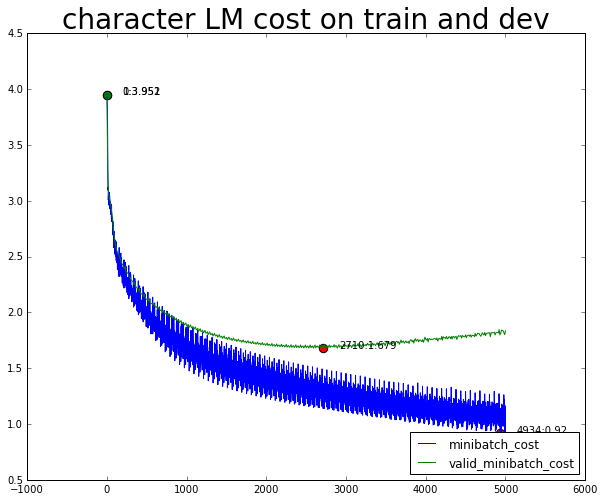

In [126]:
visualize_log(LOG_LOCATION)

In [127]:
# IDEA: compile two theano funcs that give us what we need, then iterate through the recurrent transitions manually
# func one: compute a prediction and an output for one step of the recurrent transition
# if this is the first step, we need to get the initial state, otherwise use the previous state

# add_role(self.parameters[2], INITIAL_STATE)



# one step from the beginning
def one_step(x_i, h0):

    representation = test_rnnlm.lookup.apply(x)
    inputs, gate_inputs = test_rnnlm.fork.apply(test_rnnlm.lookup.apply(x))
    inputs = inputs[0]
    gate_inputs = gate_inputs[0]
    
    states = test_rnnlm.transition.apply(inputs, gate_inputs, h0, iterate=False)
                                         
    # get cost from output layer
    output = test_rnnlm.output_layer.apply(states)
    
    y_hat = Softmax().apply(output)
    y_pred = y_hat.argmax(axis=1)
    
    return y_pred, states


In [128]:
h0 = T.matrix('h0')

one_step_out = one_step(x, h0)

test_f = theano.function([x, h0], one_step_out)

In [167]:
sample_char = word2idx['y']

In [168]:
# now iterate and concat samples
sample_len = 100

# get the initial state
current_state = test_rnnlm.transition.parameters[2].get_value()[None, :]
previous_x = np.array([[sample_char]])

sample = [sample_char]
for _ in range(sample_len):
    this_char, this_state = test_f(previous_x, current_state)
    sample.append(int(this_char))
    previous_x = np.array([[int(this_char)]])
    current_state = this_state

In [169]:
''.join([idx2word[c] for c in sample])

u'you should be a successful startups that the ones the only deciding startups` if you want to the comp'